In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix, recall_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC, LinearSVC
import spacy
import nltk
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory, detect_langs
import warnings
from collections import Counter
import pickle
from joblib import dump, load
import scikitplot as skplt
from matplotlib.colors import ListedColormap
import sklearn.metrics as metrics
# import psycopg2
# import json
# import dask.dataframe as dd

In [3]:
db_user = 'mymacbookpro'
db_password = ''
db_host = 'localhost'
db_port = 5432
database = 'mymacbookpro'

conn_postgres = f'postgres://{db_user}:{db_password}@{db_host}:{db_port}'

In [4]:
# create an sqlalchemy connection
engine = sqlalchemy.engine.create_engine(conn_postgres)
# connect using sqlalchemy
connection = engine.connect()

---

## Sampling

In [4]:
def Q(query, con=connection):
    return pd.read_sql(query, con) # database connection

In [6]:
def get_sample(sample_size=100):
    query = '''
            with reviews_1 as (
            select useful, text
            from reviews_join_table TABLESAMPLE SYSTEM(50)
            where useful = 0
            limit ''' + str(sample_size) + '''
        )
        , reviews_2 as (
            select useful, text
            from reviews_join_table TABLESAMPLE SYSTEM(50)
            where useful > 0
            limit ''' + str(sample_size) + '''
        )
        select *
        from reviews_1
        union
        select *
        from reviews_2
        '''
    result = pd.read_sql(con=engine, sql=query)
    result['target'] = result.useful.apply(lambda x: 1 if x > 0 else 0)
    return result.copy()

In [7]:
result = get_sample(50000)

In [8]:
result

,useful,text,target
0,0,!!!! Beware !!!! THEY STEAL PHONES and your da...,0
1,0,!!!Buyer beware!!!\n\nTypical sales over promi...,0
2,0,"""A good bet for the relatively inexperienced b...",0
3,0,"""As good as it gets"" for a chain family restau...",0
4,0,"""Azucar!"" is a cuban interjection to express j...",0
...,...,...,...
99995,111,After getting some mags and dim sum (brunch) w...,1
99996,114,"The celebration of all things pink, glittery, ...",1
99997,137,You won't find any country bumpkins here! \n\n...,1
99998,155,I feel like they opened up a water park in my ...,1


In [9]:
result.target.value_counts()

1    50000
0    50000
Name: target, dtype: int64

In [10]:
result.target.unique()

array([0, 1])

In [11]:
result.drop(columns=['useful'], inplace=True)

In [12]:
#save to csv
result.to_csv('sample_result_capstone.csv')

In [10]:
result = pd.read_csv('sample_result_capstone.csv')

In [6]:
result.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
#Baseline
result.target.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

## The effects of feature scaling, from Count Vectorizer to TD-IDF

##### Count vectorizer - ngram (1,1)

In [11]:
reviews_train, reviews_test = train_test_split(result, test_size=0.2, 
                                               stratify=result['target'], random_state=1)

In [132]:
print(reviews_train.shape)
print(reviews_test.shape)

(80000, 2)
(20000, 2)


In [133]:
cvec_none = CountVectorizer()

X = cvec_none.fit(reviews_train['text'])

columns = cvec_none.get_feature_names()

In [10]:
print(columns)

['00', '000', '0000', '00000000', '00044499', '000miles', '000sq', '002', '006', '007', '0079', '00am', '00hr', '00or', '00p', '00pm', '00s', '01', '010', '0100pm', '0115', '019', '01am', '01pm', '02', '02080', '021', '0254', '02am', '03', '030', '0330', '03h', '03pm', '04', '0400', '04pm', '05', '050d_xior1npcuwkbivaq', '0530', '0569', '05am', '05pm', '06', '0600', '0630am', '0650', '0677', '07', '0700', '0709', '0710', '0730', '07pm', '08', '0800', '0830', '0865', '08pm', '09', '0900', '0923', '0945', '096', '0_o', '0pm', '0stars', '0vjknr87lblvn2juatkotg', '0wlqvzuux_c', '10', '100', '1000', '10000', '100000', '1000000', '10000000', '10000000000', '1000041394', '1000ft', '1000s', '1000sf', '1000th', '1000x', '1001', '1002', '1006', '1008', '100f', '100ft', '100g', '100k', '100lb', '100m', '100mbps', '100miles', '100mpbs', '100oz', '100pp', '100s', '100sqft', '100th', '100x', '101', '1010', '10105', '10117', '1014', '1015', '1015am', '101f', '101xl', '102', '10202133799733909', '103'

In [11]:
len(cvec_none.get_feature_names())

68638

In [8]:
# foreign languages words not removed with Lang Dectect - manually taken out here with stopwords
stop = stopwords.words('english')
stop += ['00', '000', '0000', '00000000', '00044499', '000miles', '000sq', '002', '006', '007', '0079', '00am', '00hr', '00or', '00p', '00pm', '00s', '01', '010', '0100pm', '0115', '019', '01am', '01pm', '02', '02080', '021', '0254', '02am', '03', '030', '0330', '03h', '03pm', '04', '0400', '04pm', '05', '050d_xior1npcuwkbivaq', '0530', '0569', '05am', '05pm', '06', '0600', '0630am', '0650', '0677', '07', '0700', '0709', '0710', '0730', '07pm', '08', '0800', '0830', '0865', '08pm', '09', '0900', '0923', '0945', '096', '0_o', '0pm', '0stars', '0vjknr87lblvn2juatkotg', '0wlqvzuux_c', '10', '100', '1000', '10000', '100000', '1000000', '10000000', '10000000000', '1000041394', '1000ft', '1000s', '1000sf', '1000th', '1000x', '1001', '1002', '1006', '1008', '100f', '100ft', '100g', '100k', '100lb', '100m', '100mbps', '100miles', '100mpbs', '100oz', '100pp', '100s', '100sqft', '100th', '100x', '101', '1010', '10105', '10117', '1014', '1015', '1015am', '101f', '101xl', '102', '10202133799733909', '103', '1030', '10300', '1030am', '1030ish', '1030p', '1030pm', '1031', '1033', '103f', '104', '10478', '104l', '105', '1058', '10592', '106', '106th', '107', '1073741855', '1077', '107th', '108', '1080', '10810973', '1088', '108th', '109', '10955', '1099', '10a', '10am', '10bucks', '10c', '10cent', '10cm', '10day', '10days', '10ft', '10h', '10hours', '10hrs', '10ish', '10k', '10lb', '10lbs', '10m', '10min', '10mins', '10minutes', '10ml', '10more', '10mts', '10nl', '10o', '10oz', '10p', '10pcs', '10pm', '10pp', '10ppl', '10s', '10th', '10x', '10x10', '10x20', '10x6', '10xs', '10xxl', '10year', '10years', '10yr', '10yrs', '10z', '11', '110', '1100', '11030', '1107', '1109', '110f', '110ish', '110v', '110º', '111', '1115', '1118', '112', '1120', '11257', '1126', '112k', '112th', '113', '1130', '1130a', '1130am', '1133a', '1134', '114', '1140an', '1141', '1145am', '1148', '114th', '115', '1150', '115k', '115lbs', '116', '1160', '11616', '1164', '116th', '117', '117th', '118', '1180', '119', '11a', '11am', '11dollars', '11gb', '11inches', '11ish', '11k', '11p', '11pm', '11s', '11th', '11to', '11x17', '11y', '11yo', '11yr', '11yrs', '12', '120', '1200', '1200sq', '1201', '1207p', '1208', '120f', '120ft', '120ish', '120k', '120lbs', '120oz', '120pm', '121', '1212', '121297', '1215pm', '1218', '122', '12210', '1229099', '123', '1230', '1230a', '1230am', '1230p', '1230pm', '1233', '1234', '124', '1245', '125', '1250', '1250p', '125th', '126', '127', '128', '12837a3s1', '1284', '1287', '129', '129824', '1299', '12am', '12c', '12feet', '12ft', '12hrs', '12inch', '12ish', '12k', '12noon', '12oz', '12p', '12pm', '12pz', '12th', '12us', '12usd', '12x1', '12x10', '12yrs', '12ys', '13', '130', '1300', '13055', '130am', '130k', '130pm', '130th', '130x4', '131', '1310', '132', '133', '1330', '1333', '134', '135', '1350', '1350658', '1356', '136', '137', '1375', '138', '139', '1396', '13999', '13am', '13ish', '13k', '13mi', '13mo', '13pm', '13s', '13th', '13yo', '13yrs', '13ys', '14', '140', '1400', '14000', '1400sqft', '1400t', '1403', '1403008', '140438681', '1409', '140mm', '141', '1410', '142', '142171873', '143', '1430', '144', '145', '1453', '1455706632', '145f', '146', '147', '14797', '148', '149', '1495', '1499', '149962818358775', '14gb', '14h', '14ish', '14k', '14mo', '14oz', '14pm', '14pp', '14th', '15', '150', '1500', '15000', '1501', '1504', '1506', '150a', '150g', '150k', '150km', '151', '152', '15232', '15238', '1535', '154', '155', '156', '157', '158', '159', '15982', '15a', '15am', '15c', '15ish', '15k', '15lbs', '15m', '15min', '15mins', '15minutes', '15monthly', '15p', '15pc', '15people', '15pm', '15pp', '15ppl', '15s', '15th', '15x35', '15x50', '15yr', '15yrs', '16', '160', '1600', '16000', '160dpi', '160gb', '160lbs', '161', '1612', '162', '1625', '163', '1632', '1634', '164', '1645', '165', '1650', '166', '1664', '167438895870', '16797', '168', '168482', '16856', '169', '16am', '16bit', '16hours', '16mph', '16oz', '16pcs', '16pp', '16st', '16th', '16yr', '17', '170', '1700', '170ish', '170k', '170m', '171', '172', '17317', '174', '175', '1750', '175lb', '176', '177', '1777', '178', '179', '1799', '17c', '17ish', '17million', '17of', '17th', '17year', '17yr', '18', '180', '1800', '1800hrs', '1800s', '1800walgreens', '180g', '181', '1812', '182', '183', '184', '1842', '1845', '185', '1850', '186', '1860', '1863', '187', '1871', '18797', '188', '1880', '1889', '189', '1890', '1891', '1897', '1899', '18a', '18inch', '18k', '18kt', '18lb', '18mbps', '18oz', '18pedicure', '18pm', '18rd', '18th', '18yr', '19', '190', '1900', '1900s', '19056994008', '1908', '1909', '191', '1911', '1911s', '1916', '1917', '1920', '1924', '1928', '193', '1930', '1930s', '1932', '1933', '1934', '1938', '1939', '1940', '19400', '1940s', '1941', '1942', '1943', '1944', '1946', '1948', '195', '1950', '1950s', '1954', '1955', '1956', '1957', '1959', '1960', '1960s', '1962', '1964', '19642', '1965', '1966', '1967', '1968', '1969', '1970', '1970s', '1971', '1971in', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '198', '1980', '1980s', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '199x', '19am', '19april17', '19ave', '19north', '19pm', '19th', '19yr', '1a', '1am', '1and', '1b', '1bath', '1bd', '1bed', '1beef', '1bqbd18j_mjo5nvks53buq', '1br', '1brat', '1c', '1c3', '1cc', '1e1', '1fl', '1ft', '1g2', '1h', '1hour', '1hr', '1hr45mins', '1hrs', '1ish', '1k', '1kg', '1kvdxxurxo7xbotp8ddz1w', '1l', '1lb', '1lbs', '1lyvcsu7xj8d_uihvcb0qw', '1m', '1min', '1mo', '1o', '1o6pdmt73lvmzislibfsnmgbrqprvf_vce4zdor2tkxc', '1oak', '1october', '1of', '1or', '1our', '1oz', '1p', '1pc', '1ply', '1pm', '1pound', '1rm', '1s', '1st', '1star', '1sty_2n5mhdbcntvmlkiannq', '1th', '1tine', '1uc', '1up', '1week', '1x', '1y', '1year', '1yr', '20', '200', '2000', '20000', '200000411', '2000k', '2000s', '2000th', '2000w', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '200f', '200ft', '200k', '200km', '200lbs', '200m', '200mb', '200pp', '200th', '201', '2010', '20100209', '2011', '2012', '2013', '2014', '20147', '2015', '2015my', '2016', '201612200276', '2017', '2018', '2019', '20190506150859', '2019s', '202', '2020', '2021', '20215', '2022', '20252', '203', '2031', '204', '2045', '2047578', '205', '205888', '206', '2064', '207', '2070', '2076', '208', '2085', '209', '2099', '20am', '20cad', '20dollars', '20h', '20ish', '20jelly', '20k', '20l', '20may16', '20mb', '20miles', '20min', '20mins', '20minutes', '20mnt', '20oz', '20pc', '20pm', '20pmflight', '20pp', '20ppl', '20s', '20th', '20vegas', '20x', '20yr', '20yrs', '21', '210', '2100', '2104', '210lbs', '211', '212', '213', '215', '216', '217', '218', '219', '21h', '21k', '21pm', '21st', '22', '220', '2200', '220mg', '220v', '221', '2211', '222', '2223', '2233', '2242', '2242080', '225', '2250sq', '2256', '226', '226074', '2266', '227', '2271take_out', '228', '2289', '228i', '22h', '22k', '22lbs', '22lr', '22may16', '22mg', '22nd', '22oz', '22pm', '23', '230', '2300', '230am', '230p', '230pm', '231', '233', '2334', '234', '235', '2350', '236', '238475230984572098347520983475290837452908374598273458723457', '2386', '239', '239874938475092734985732984076th', '23am', '23apr', '23april17', '23k', '23oz', '23pm', '23rd', '23yrs', '24', '240', '2400', '2400sqft', '241', '242', '2421', '243', '244', '245', '245am', '246', '24797', '248', '24am', '24h', '24hour', '24hours', '24hr', '24hrs', '24inch', '24k', '24lbs', '24mph', '24oz', '24th', '24x36', '24x7', '25', '250', '2500', '250g', '250gb', '250lb', '250sq', '2510', '254', '255', '2550', '256', '2560', '258', '2580', '2584', '2586', '259', '25am', '25apr2018', '25cents', '25k', '25l', '25lbs', '25loc', '25m', '25min', '25mins', '25minutes', '25mn', '25pm', '25pp', '25th', '25yo', '25yrs', '26', '260', '2600', '2607', '2608', '261', '2614', '2620', '2641', '265', '266', '267', '268', '26ft', '26oz', '26th', '27', '270', '2700', '271', '272', '273', '274', '27491', '275', '277', '278585471', '2797', '27dollar', '27k', '27pp', '27th', '28', '280', '2800', '2803', '281', '28117', '28202', '28227', '2825', '28250', '28273', '284', '285', '287', '288', '289', '28th', '29', '290', '2900', '2908', '2916', '2917', '2919', '292', '294', '2948', '295', '299', '29k', '29pm', '29th', '2adults', '2am', '2and', '2as', '2b46d66b', '2b6', '2ba', '2bath', '2bd', '2bed', '2bhlpvj', '2biq1lf', '2br', '2bucks', '2cents', '2d', '2days', '2daystiltexas', '2dogs', '2double', '2dppwfu', '2e', '2e0', '2e6lwki', '2eggs', '2fl', '2for1', '2ft', '2ful', '2g4azjm', '2grand', '2hoits', '2hour', '2hours', '2hr', '2hrs', '2hrstotally', '2ish', '2k', '2kids', '2l', '2lb', '2lbs', '2m', '2min', '2mins', '2mm', '2nd', '2ndary', '2ne1', '2night', '2ordered', '2oz', '2p', '2pc', '2pcs', '2pm', '2ryzruo', '2s', '2sake', '2shrimps', '2sisters', '2size', '2slices', '2star', '2thumbs', '2u', '2ufc1pr2yuu', '2weeks', '2weqs', '2x', '2x2', '2x3', '2x4', '2xl', '2xlp', '2year', '2years', '2yo', '2yr', '2yrs', '30', '300', '3000', '300c', '300ft', '300g', '300lbs', '300mrsp', '300zx', '301', '302', '3021', '3028', '303', '305', '3054', '305pm', '305th', '306', '307', '30854', '309', '30a', '30am', '30an', '30b', '30bucks', '30c', '30cad', '30day', '30daysofyelp', '30e', '30ft', '30i', '30iish', '30in', '30ish', '30jul2019', '30k', '30lb', '30lbs', '30miles', '30mim', '30min', '30mins', '30minutes', '30mn', '30mns', '30p', '30pm', '30s', '30secs', '30something', '30th', '30with', '30x', '30years', '30yrs', '31', '310', '3100', '311', '312', '3131', '3137', '315', '3151', '316', '318', '319', '31a', '31b', '31k', '31pm', '31st', '32', '320', '3200', '321', '3213', '322', '3228', '323', '324', '325', '325i', '328', '3282', '328i', '328xi', '32c', '32d', '32in', '32k', '32nd', '32oz', '33', '330', '3300', '330p', '330pm', '331', '333', '3330', '335', '337', '3370', '3377', '338', 
         '33800', '339', '3393', '33am', '33d9z80', '33ft', '33oz', '33pm', '33rd', '33rpm', '34', '340', '3400', '3411', '342', '343', '345', '3451', '346', '3475', '3476', '348', '34a', '34am', '34g', '34mi', '34pm', '34th', '35', '350', '3500', '350lbs', '350ml', '35263351', '353295', '355', '3555', '357', '3598', '35am', '35cents', '35dollar', '35ish', '35k', '35lbs', '35min', '35mins', '35oz', '35pm', '35th', '36', '360', '361', '3640', '365', '36529', '3655', '366', '3663', '367', '368', '369', '36d', '36k', '36th', '37', '370', '3700', '370z', '371', '3717', '374', '375', '3750', '37500', '376', '377', '379', '37am', '37st', '37th', '38', '380', '3800', '38000', '382', '3845', '385', '386', '3892103', '38951064', '38cm', '38k', '38lbs', '38pm', '38s', '38st', '38th', '39', '390', '3901', '391774', '392', '3935', '3937', '394', '395', '396', '3961', '39666088', '3971', '398', '399', '39am', '39ish', '39th', '3a', '3abd', '3am', '3br', '3c', '3cm', '3cxwopa', '3d', '3drinks', '3ds', '3e', '3feet', '3fl', '3g', '3hours', '3hr', '3hrs', '3ish', '3k', '3lb', '3lw', '3m', '3m2', '3m4', '3min', '3mins', '3minutes', '3month', '3months', '3nl', '3nts', '3or', '3oz', '3p', '3pc', '3pm', '3pp', '3rd', '3rm', '3s', '3some', '3stablishment', '3stars', '3suu_0eajijhhcrdugiava', '3time', '3times', '3weeks', '3x', '3x2', '3x3', '3x3x3', '3x3x3x3x3x3x3', '3xpy8vv6y1q', '3xs', '3y', '3years', '3yo', '3yr', '3yrd', '3yrs', '40', '400', '4000', '4000sqft', '400am', '400th', '401', '4015', '401k', '402', '403', '4035', '404', '404n', '405', '4066', '407', '409', '40a', '40am', '40bucks', '40f', '40ish', '40k', '40kph', '40lb', '40lbs', '40mg', '40min', '40mins', '40minutes', '40mn', '40oz', '40pcs', '40pm', '40psi', '40s', '40th', '40weeks', '40yrs', '41', '410', '4105', '411', '411th', '412', '413', '414', '415', '416', '417', '418', '419', '41ft', '41k', '41pm', '42', '420', '4200', '4206', '420a', '420p', '421', '422', '424', '425', '426', '428', '4280', '429', '42a', '42am', '42oz', '42pm', '43', '430', '4301', '4302', '430am', '430pm', '431', '4313', '4325', '434', '4355', '43k', '43pm', '43rd', '44', '440', '4400', '443', '445', '446', '4469', '448', '44oz', '44rth', '44th', '45', '450', '4500', '4500sq', '4525', '4528', '455', '4557', '4575', '459', '4594', '45a', '45acp', '45am', '45ish', '45k', '45min', '45mins', '45minutes', '45p', '45pm', '45s', '45th', '45usd', '45years', '46', '460', '465', '4653', '468', '469', '46lbs', '46pm', '46th', '47', '470', '4700', '474', '475', '476', '479', '47k', '47p', '47pm', '47th', '48', '480', '480termites', '4827', '483', '484', '485', '487', '4888', '48h', '48hr', '48in', '48k', '48th', '49', '490', '4910', '4923', '495', '495684059640596805698', '499', '49c', '49cent', '49er', '49ers', '49min', '49pm', '49r', '49th', '4a', '4am', '4b', '4c', '4d', '4e', '4ever', '4fc85th0ookwrhbqj8p1', '4g', '4got', '4hour', '4hours', '4hr', '4hrs', '4ikvr3w', '4ish', '4k', '4kids', '4lb', '4lbs', '4mm', '4mph', '4my', '4oz', '4p', '4pc', '4per', '4pieces', '4pm', '4pmish', '4ppl', '4runner', '4s', '4sqft', '4star', '4stars', '4th', '4ths', '4times', '4to5', '4unknown', '4wd', '4wks', '4x', '4x100', '4x4', '4x4animal', '4x6', '4x6ft', '4xl', '4year', '4years', '4yo', '4yr', '4yrs', '50', '500', '5000', '5000km', '5001', '500g', '500kbps', '500lbs', '500mb', '500ml', '500th', '501', '50116', '502', '50316', '505', '506', '5065974', '509944220', '50am', '50c', '50ca', '50cent', '50cents', '50cm', '50dll', '50ish', '50k', '50lbs', '50mbps', '50mg', '50min', '50mins', '50ml', '50mph', '50p', '50pm', '50pound', '50pp', '50s', '50th', '50ways2ragnar', '50ways2ragnarv2', '50x50', '51', '510', '5100', '5111', '512', '5125', '514', '51pm', '51st', '52', '520', '5200', '521', '523', '525', '527', '52nd', '52pm', '53', '530', '530i', '530pm', '531', '532', '53704', '539', '53k', '53pm', '53rd', '54', '540', '5400', '540pm', '541', '543', '5440', '545', '545pm', '54am', '54th', '55', '550', '5500', '55000', '5509', '550i', '55142', '552', '5527', '555', '556', '5570', '558', '559', '55a', '55am', '55ish', '55min', '55p', '55pm', '55pp', '55th', '56', '560', '561', '564', '565', '569', '56k', '56th', '57', '570s', '5712', '5733', '574s', '575', '579', '57am', '57pm', '57th', '58', '580', '5800', '584', '585', '588', '589', '58cm', '58per', '58pm', '58th', '59', '595', '598', '5987', '599', '59am', '59g', '59th', '5a', '5ake', '5am', '5and', '5c2011002', '5cents', '5church', '5e', '5er', '5ft', '5g', '5guys', '5h', '5he', '5hours', '5hp24', '5hr', '5hrs', '5ish', '5k', '5kms', '5ks', '5l', '5lb', '5lbs', '5m', '5min', '5mins', '5mo', '5months', '5nl', '5off', '5or', '5oz', '5p', '5pc', '5pcs', '5pm', '5ppl', '5s', '5s17', '5star', '5stars', '5th', '5thumbs', '5usd', '5w30', '5weeks', '5x', '5x11', '5x3', '5x7', '5xs', '5y', '5years', '5yr', '5yrs', '60', '600', '6000', '600mg', '602', '60259', '6026860159', '603', '607', '608', '6083', '60c', '60every', '60g', '60k', '60l', '60lb', '60lbs', '60min', '60mins', '60mph', '60pcs', '60s', '60sec', '60th', '61', '610', '611', '612', '613', '615', '615p', '615pm', '617', '618', '61a', '61st', '62', '620', '6200', '620am', '621', '623', '625', '6256', '627pm', '628', '6290', '62nf', '63', '630', '6301', '630am', '630pm', '6320', '6327', '635', '637', '6385', '64', '640', '6400', '6409', '642', '645', '645pm', '646', '647', '648', '649', '64ish', '64oz', '64th', '65', '650', '6500', '6506', '650i', '650pm', '650w', '6527', '654', '6549', '655', '656', '658', '65th', '65yo', '66', '661', '6620', '6633', '6670510', '6683', '6689', '66th', '67', '672', '676', '677', '6788', '679', '67t', '67th', '68', '680', '680ml', '683', '686', '6898', '68th', '69', '6906', '6920', '69277', '695', '699', '69c', '69th', '6a', '6am', '6and1', '6days', '6dollar', '6e', '6ft', '6h2k8bp3eimk5dx9c9d5nw', '6hours', '6hrs', '6in', '6ish', '6l', '6lb', '6lbs', '6min', '6mins', '6minutes', '6mo', '6month', '6months', '6oz', '6p', '6pc', '6pk', '6pm', '6s', '6th', '6weeks', '6x', '6x6', '6year', '6years', '6yo', '6yr', '70', '700', '7000', '700b', '700sq', '700th', '701', '7013611830', '7018', '701pm', '702', '7025', '7025138012', '702vip', '704', '7040', '7045', '705', '70ish', '70k', '70l', '70lb', '70min', '70mph', '70pp', '70s', '71', '710', '710am', '711', '7120', '715', '715767', '715pm', '717', '719', '71b', '71k', '72', '720', '722', '723', '725', '73', '730', '7300', '730am', '730p', '730pm', '734', '735', '736', '739', '73k', '73rd', '73w4x9xosg7lfr2omieicq', '74', '740', '7401', '741', '7430', '744', '745', '745pm', '747', '749', '75', '750', '7500', '750m', '750ml', '751', '7520', '753', '758', '7597', '75for', '75ft', '75th', '75y', '76', '760', '762', '76k', '76o', '76rrdwelntu', '77', '772', '773', '775', '777', '777888999', '778', '77906321824', '78', '7800', '7816', '784069', '788', '78th', '79', '790', '790sq', '795', '797', '7988', '799', '79c', '7a', '7am', '7bux', '7eleven', '7ft', '7gg0', '7in', '7ish', '7items', '7k', '7lb', '7m', '7mbps', '7min', '7mins', '7minutes', '7oz', '7p', '7plus', '7pm', '7s', '7series', '7th', '7to', '7up', '7x', '7years', '7yr', '7yrs', '80', '800', '8000', '803', '8032', '804', '805', '808', '8084', '809', '80k', '80lbs', '80s', '80th', '81', '810', '8100', '8133', '814', '815', '815a', '816', '8175', '818', '819', '81st', '81yrs', '82', '820', '826nyc', '828', '82lg', '83', '830', '830a', '830am', '830ish', '830pm', '832', '833975121rt0001', '835', '8351', '8383', '839', '83rd', '84', '840', '8400', '841', '8419', '844', '845', '845am', '845pm', '85', '850', '8500', '85022', '85034', '85085', '851', '85206', '85224', '85254', '85257', '85281', '85296', '8534', '855', '8585', '85ev04z', '86', '860', '866', '866834', '867', '8684', '86d', '87', '8700', '875', '88', '8804', '8825', '883', '888', '888westjet', '88lbs', '88th', '89', '890', '89014', '89032', '89052', '89104', '89118', '89119', '89123', '89130', '89135', '89144', '89145', '89148', '893', '8934', '8944', '899', '89lbs', '89th', '8a', '8am', '8c', '8c1c7qwxzzcmgk_8h4a', '8cad', '8ft', '8h30', '8hrs', '8in', '8ish', '8k', '8lbs', '8min', '8mins', '8mo', '8mos', '8ntovkrkjyepvqouklya0q', '8oz', '8p', '8pc', '8pgtu034n', '8plus', '8pm', '8th', '8weeks', '8x10', '8years', '8yr', '8yrs', '90', '900', '9000', '901', '90210', '9023', '9028', '9037', '905', '908', '90ish', '90k', '90min', '90mins', '90o', '90pp', '90s', '90th', '91', '910', '9100', '911', '915', '917', '918', '91st', '92', '9206', '921', '9210', '926', '928', '92fs', '92nd', '92sew2j6fys', '93', '930', '93000', '930a', '930am', '930ish', '930pm', '931', '936pm', '937', '93k', '94', '940', '9405', '944', '945', '9451', '945a', '945pm', '95', '950', '9500', '96', '964', '967', '968', '96inch', '96km', '96oz', '97', '9731', '975', '978', '98', '980', '988', '99', '9900', '9910', '995', '997', '999', '99c', '99cent', '99cents', '99pp', '99th', '99yrs', '99z', '9a', '9am', '9dollar', '9f', '9foot', '9ish', '9k', '9m', '9mbps', '9minutes', '9mm', '9months', '9oz', '9p', '9piece', '9pm', '9pmish', '9q_tqdx5st0qxgqlapoiog', '9round', '9rounds', '9th', '9tots', '9x5', '9y', '9yo', '9yr', '9yrs', '__', '___', '____', '_____', '______', '_______', '________', '_________', '__________', '___________', '____________', '______________', '__________________', '___________________', '________________________', '_______________________________', '______________________________________________________', '__________________________________________________________________________', '_____mind', '_always_', '_bad_', '_car_', '_don', '_frenchman', '_not_', '_sour', '_that_', '_think_', 'a1', 'a111', 'a14', 'a18', 'a1c', 'a2', 'a21', 'a24', 'a330', 'a3d9hokajzyvj6cr8h3ung', 'a3dc4817a1', 'a4', 'a5', 'a507892', 'a7', 'a7ieezkpm3tjplm9wgsubq', 'a90', 'a_s', 'aa', 'aa5286', 'árabe', 'árbol', 'área', 'éclair', 'éclusiers', 'écolier', 'écrasées', 'également', 'élan', 'élysées', 'énergie', 'épicerie', 'était', 'étouffée', 'être', 'órale', 'über', 'ķnows', 
    'イタリアンなのてちょっと重いハスタとかを想像していましたか小さなティッシュてとっても軽く', '色々試せて良かったてす', 'イタリアンなのでちょっと重いパスタとかを想像していましたが小さなディッシュでとっても軽く', 'のてちょっと重いハスタとかを想像していましたか小さなティッシュてとっても軽く', '色々試せて', '一i', '一直问我们大几', '五十五', '以后', '但是他什么都不说', '你好', '你很屌吗', '你服务什么了吗', '傻屌男', '傻逼', '先说15', '分单每张卡要收两毛钱', '别信给一分的', '十五', '十分失望對素菜麵的水準', '反问我们就差这几毛钱吗', '哇塞这家超好吃', '四川', '回锅肉', '垃圾狗店', '女子公寓', '小费随口说', '小龙包', '很厉害吗', '很成都很重庆哦', '懂吗', '我也他妈1毛不多给你', '我们发现是20', '我们大几你就能很屌吗', '我有100美金扔水里', '是那就20', '正宗德庄火锅', '残念', '涼粉楊枝金露', '湯圓', '炸酱面', '点解会有牛柏葉喺我哋碟麵到㗎', '烤鸭两吃', '然后改口18', '直接接收', '真的好棒', '破店很厉害吗', '老坛酸菜米线', '色々試せて良かったです', '芝麻糊', '薑汁撞奶', '蝦餃', '西北', '说我们不要浪费他的时间', '豆腐花', '跟国内德庄像', '还偷偷用台山话骂我们', '还有青城山椒麻国', '金汤娃娃菜', '铁板茄子', '雨露金荁', '霸王雞chicken', '鬍鬚張', '麻婆豆腐', '黑糯米杏仁糊', '黑芝麻雞蛋仔配綠茶雪糕', '鼎泰丰', '110o', 'arabe', 'arbol', 'area', 'eclair', 'eclusiers', 'ecolier', 'ecrasees', 'egalement', 'elan', 'elysees', 'energie', 'epicerie', 'etait', 'etouffee', 'etre', 'knows', 'orale', 'uber', 'イタリアンな良かったてす']

In [14]:
# Lets use the stop_words argument to remove words like "and, the a"
cvec = CountVectorizer(lowercase=True, stop_words=stop, strip_accents='unicode')

# Fit out vectorizer using the train_data
cvec.fit(reviews_train['text'])

#transform training data to sparse matrix
cvec_mat = cvec.transform(reviews_train['text'])

# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
print()
# number of different words
print(len(words))

['beetnik', 'beeton', 'beetroot', 'beets', 'beetuz', 'beewise', 'beeyach', 'beezy', 'befitting', 'befor', 'beforehand', 'befriend', 'befriended', 'befuddled', 'beg', 'began', 'begetter', 'begetting', 'beggars', 'begged']

65796


 We still have the same number of rows but the vectorization has converted every word, 
 or what is believed to be a word, from our test data into a feature.  This is like dummy coded
 variables for words except that we have counts rather than just occurances.

In [17]:
# Count work appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [18]:
# cumulative sum of transformed matrix
csum = word_counter(cvec_mat)
csum

array([ 1, 63,  1, ...,  1,  2,  1], dtype=int64)

In [18]:
# sorts words by frequency
from operator import itemgetter

def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                        key=itemgetter(1), reverse=True)
    return sort_result

In [37]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(words, csum), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.head(20)

,frequency
word,
food,40722
place,38429
good,38173
great,34433
service,29406
time,28402
like,28019
get,26898
one,26661


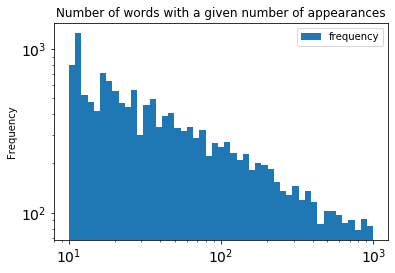

In [39]:
# Plotting the word frequency distribution, we observe Zipf's law
df_word_frequency.plot(kind='hist', bins=np.logspace(1,3,50), 
                      loglog=True, 
                      title='Number of words with a given number of appearances', 
                      fontsize=14)
plt.show()

## Fit Regression Model

In [15]:
X_train = cvec_mat 
y_train = reviews_train["target"]
X_test = cvec.transform(reviews_test["text"])
y_test = reviews_test["target"]

In [22]:
lr = LogisticRegression(solver='saga', max_iter=10000)
lr.fit(X_train, y_train)
print('Train score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print('CV mean:', cross_val_score(lr, X_train, y_train).mean())

Train score: 0.8072375
Test score: 0.60085
CV mean: 0.5949125000000001


In [54]:
dump(lr, 'lr_cvec.joblib') 

In [16]:
lr_cvec = load('lr_cvec.joblib')

### Confusion Matrix, AUC, ROC

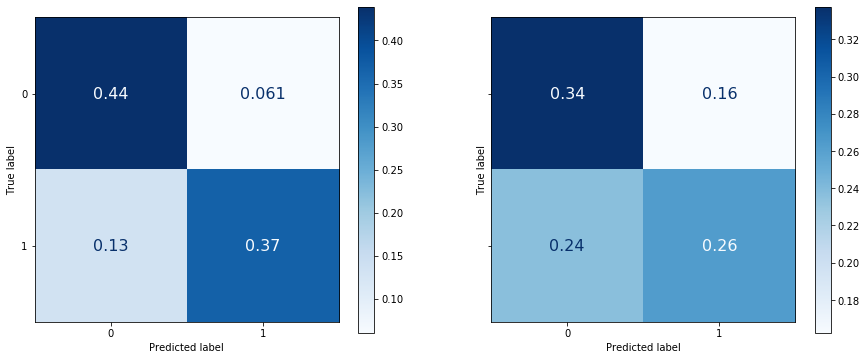

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
plot_confusion_matrix(lr_cvec, X_train, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(lr_cvec, X_test, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)

plt.show()

In [19]:
yhat_test = lr_cvec.predict(X_test)
yhat_train = lr_cvec.predict(X_train)
print(classification_report(y_train, yhat_train))
print()
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     40000
           1       0.86      0.74      0.79     40000

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000


              precision    recall  f1-score   support

           0       0.59      0.68      0.63     10000
           1       0.62      0.53      0.57     10000

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



In [20]:
probabilities_train = lr_cvec.predict_proba(X_train)
probabilities_test = lr_cvec.predict_proba(X_test)

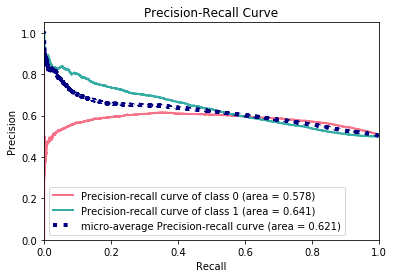

In [22]:
cmap = ListedColormap(sns.color_palette("husl", len(lr_cvec.classes_)))
skplt.metrics.plot_precision_recall(y_test, probabilities_test, cmap=cmap)
plt.show()

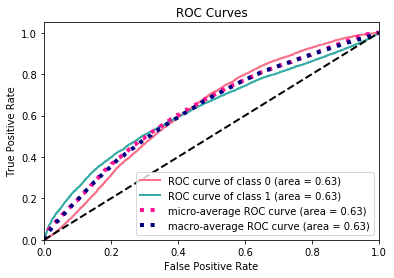

In [23]:
skplt.metrics.plot_roc(y_test, probabilities_test, cmap=cmap)
plt.show()

## Count Vectorizer ngrams (2, 2)

In [27]:
# Lets use the stop_words argument to remove words like "and, the a"
cvec = CountVectorizer(lowercase=True, stop_words=stop, strip_accents='unicode', ngram_range=(2,2))

# Fit out vectorizer using the train_data
cvec.fit(reviews_train['text'])

#transform training data to sparse matrix
cvec_mat = cvec.transform(reviews_train['text'])

# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
print()
# number of different words
print(len(words))

# 1,922,891 features now included

['accommodating disappointed', 'accommodating discovered', 'accommodating doctor', 'accommodating dr', 'accommodating drink', 'accommodating drinks', 'accommodating drive', 'accommodating eager', 'accommodating eastern', 'accommodating easy', 'accommodating efficient', 'accommodating egg', 'accommodating employees', 'accommodating end', 'accommodating enough', 'accommodating ensuring', 'accommodating escape', 'accommodating especially', 'accommodating even', 'accommodating event']

1922891


In [56]:
csum = word_counter(cvec_mat)
csum

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [57]:
cvec_mat.sum(axis=0)

matrix([[1, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [58]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(words, csum), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.head(20)

,frequency
word,
customer service,4628
first time,3688
go back,3264
come back,3254
highly recommend,3061
really good,2387
ice cream,2066
food good,2013
pretty good,1973


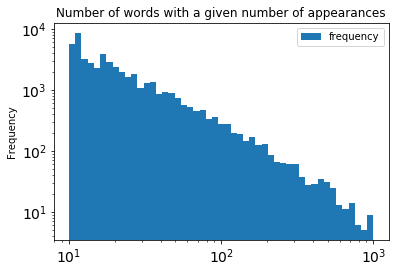

In [59]:
# Plotting the word frequency distribution, we observe Zipf's law
df_word_frequency.plot(kind='hist', bins=np.logspace(1,3,50), 
                      loglog=True, 
                      title='Number of words with a given number of appearances', 
                      fontsize=14)
plt.show()

In [28]:
X_train = cvec_mat
y_train = reviews_train["target"]
X_test = cvec.transform(reviews_test["text"])
y_test = reviews_test["target"]

In [117]:
lr_ngrams22 = LogisticRegression(solver='saga', max_iter=10000)
lr_ngrams22.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
print('Train score:', lr_ngrams22.score(X_train, y_train))
print('Test score:', lr_ngrams22.score(X_test, y_test))
cv_scores = cross_val_score(lr_ngrams22, X_train, y_train, cv=5)
print('CV mean:', cross_val_score(lr_ngrams22, X_train, y_train).mean())

Train score: 0.999125
Test score: 0.58875
CV mean: 0.5897


In [63]:
dump(lr_ngrams22, 'lr_ngrams22.joblib') 

In [29]:
lr_ngrams22 = load('lr_ngrams22.joblib') 

### Confusion Matrix, ROC, AUC, precision-recall curve 

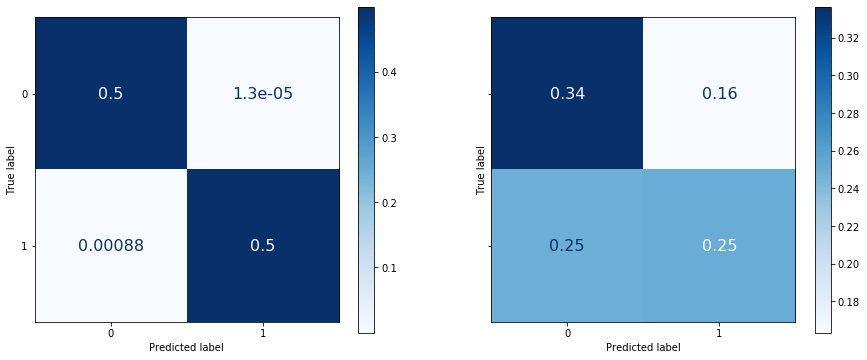

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
plot_confusion_matrix(lr_ngrams22, X_train, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(lr_ngrams22, X_test, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)

plt.show()

In [18]:
yhat_test = lr_ngrams22.predict(X_test)
yhat_train = lr_ngrams22.predict(X_train)
print(classification_report(y_train, yhat_train))
print()
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00     40000

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


              precision    recall  f1-score   support

           0       0.58      0.67      0.62     10000
           1       0.61      0.50      0.55     10000

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.58     20000
weighted avg       0.59      0.59      0.58     20000



In [120]:
probabilities_train = lr_ngrams22.predict_proba(X_train)
probabilities_test = lr_ngrams22.predict_proba(X_test)

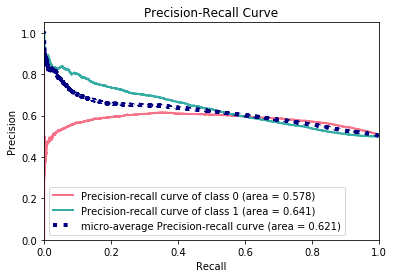

In [24]:
skplt.metrics.plot_precision_recall(y_test, probabilities_test, cmap=cmap)
plt.show()

In [ ]:
skplt.metrics.plot_roc(y_test, probabilities_test, cmap=cmap)
plt.show()

## TF-IDF & Logistic Regression

In [31]:
# Lets use the stop_words argument to remove words like "and, the a"
tfidf = TfidfVectorizer(stop_words=stop, lowercase = True, 
                              strip_accents='unicode', ngram_range=(1,1))

# Fit out vectorizer using the train_data
tfidf.fit(reviews_train['text'])

#transform training data to sparse matrix
tfidf_mat = tfidf.transform(reviews_train['text'])

# words occuring
words = tfidf.get_feature_names()
print(words[0:1000])
print()
# number of different words
print(len(words))

['TM', 'aaa', 'aaaaaaaamazingly', 'aaaaaaanywhere', 'aaaaaah', 'aaaaaalright', 'aaaaah', 'aaaaahing', 'aaaaamazing', 'aaaaannd', 'aaaaannyway', 'aaaah', 'aaaahhh', 'aaaahhhs', 'aaaahing', 'aaaal', 'aaaalll', 'aaaalllll', 'aaaamazing', 'aaaand', 'aaaanyway', 'aaaazing', 'aaah', 'aaahhh', 'aaahhhmaaazing', 'aaamazing', 'aaand', 'aaarrrgghhhhh', 'aaawesooome', 'aac', 'aack', 'aafter', 'aah', 'aahahahaha', 'aahhhmaaayzing', 'aaia', 'aaked', 'aaliyah', 'aall', 'aam', 'aamazing', 'aamazingly', 'aamco', 'aaoge', 'aaron', 'aarp', 'aarti', 'aas', 'aaye', 'aayyyeeee', 'aayyyyy', 'ab', 'aback', 'abacus', 'abadan', 'abadi', 'abagail', 'abagails', 'abalone', 'abandon', 'abandoned', 'abatement', 'abattoir', 'abba', 'abbas', 'abbey', 'abbott', 'abbreviated', 'abbreviation', 'abbruo', 'abby', 'abc', 'abc123', 'abd', 'abdc', 'abdelsayed', 'abdicates', 'abdomen', 'abdominal', 'abdul', 'abe', 'abel', 'abele', 'abeo', 'aber', 'abercrombie', 'aberration', 'aberrations', 'aberthon', 'abf', 'abhor', 'abhorre

In [34]:
csum = word_counter(tfidf_mat)
csum

array([0.42613129, 9.08795451, 0.34159143, ..., 0.34126697, 0.41260929,
       0.13979612])

In [35]:
tfidf_mat.sum(axis=0)

matrix([[0.42613129, 9.08795451, 0.34159143, ..., 0.34126697, 0.41260929,
         0.13979612]])

In [38]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(words, csum), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.head(20)

,frequency
word,
food,2375.971576
great,2232.544712
good,2114.870602
place,2107.319117
service,1837.308624
time,1495.744831
back,1385.411945
get,1364.063737
like,1363.871872


## Pipeline TF-IDF/ LogReg & GridSearch for TF-IDF (ngram=1,1)

In [24]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop, lowercase = True, strip_accents='unicode')),
    ('logreg',LogisticRegression(solver = 'saga', max_iter = 10000))
                ])
param_grid = {'tfidf__min_df':[10,20,30,40], 
              'tfidf__max_features':[1000,10000,5000]}

model = GridSearchCV(pipe, param_grid = param_grid, verbose = 2, cv = 5)

model.fit(reviews_train['text'], reviews_train['target'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=   7.5s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=   7.4s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=   7.9s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................


KeyboardInterrupt: 

In [49]:
print('Best Parameters:')
print(model.best_params_)
print('Best estimator mean cross validated training score:')
print(model.best_score_)
print('Best estimator score on the full training set:')
print(model.score(reviews_train['text'], reviews_train['target']))
print('Best estimator score on the test set:')
print(model.score(reviews_test['text'], reviews_test['target']))

Best Parameters:
{'tfidf__max_features': 1000, 'tfidf__min_df': 20}
Best estimator mean cross validated training score:
0.6255124999999999
Best estimator score on the full training set:
0.6394125
Best estimator score on the test set:
0.62945


In [50]:
dump(model, 'tfidf_logr.joblib') 

['tfidf_logr.joblib']

In [18]:
tfidf_logr = load('tfidf_logr.joblib')

In [19]:
tfidf_logr

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

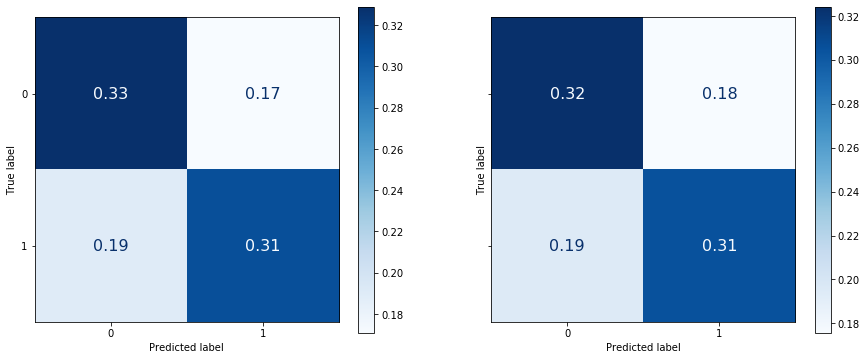

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
plot_confusion_matrix(model, reviews_train['text'], reviews_train['target'], cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(model, reviews_test['text'], reviews_test['target'], cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)

plt.show()

In [66]:
yhat_test = model.predict(reviews_test['text'])
yhat_train = model.predict(reviews_train['text'])
print(classification_report(reviews_train['target'], yhat_train))
print()
print(classification_report(reviews_test['target'], yhat_test))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65     40000
           1       0.64      0.62      0.63     40000

    accuracy                           0.64     80000
   macro avg       0.64      0.64      0.64     80000
weighted avg       0.64      0.64      0.64     80000


              precision    recall  f1-score   support

           0       0.62      0.65      0.64     10000
           1       0.63      0.61      0.62     10000

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



In [68]:
probabilities_train = model.predict_proba(reviews_train['text'])
probabilities_test = model.predict_proba(reviews_test['text'])

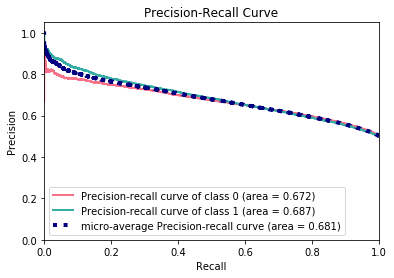

In [70]:
cmap = ListedColormap(sns.color_palette("husl", len(model.classes_)))
skplt.metrics.plot_precision_recall(reviews_test['target'], probabilities_test, cmap=cmap)
plt.show()

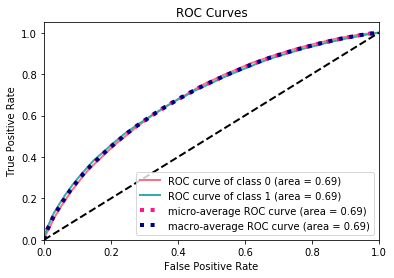

In [71]:
skplt.metrics.plot_roc(reviews_test['target'], probabilities_test, cmap=cmap)
plt.show()

## Looking at ngrams (2,2) and whether the new features add anything to the model

In [15]:
# Lets use the stop_words argument to remove words like "and, the a"
tfidf2 = TfidfVectorizer(stop_words=stop, lowercase = True, 
                              strip_accents='unicode', ngram_range=(2,2))

# Fit out vectorizer using the train_data
tfidf2.fit(reviews_train['text'])

#transform training data to sparse matrix
tfidf_mat = tfidf2.transform(reviews_train['text'])

# words occuring
words = tfidf2.get_feature_names()
print(words[0:1000])
print()
# number of different words
print(len(words))

['TM come', 'aaa ability', 'aaa absolutely', 'aaa back', 'aaa ballantyne', 'aaa beef', 'aaa came', 'aaa camelback', 'aaa car', 'aaa card', 'aaa complaint', 'aaa coupon', 'aaa customers', 'aaa cvs', 'aaa cynthia', 'aaa discount', 'aaa effective', 'aaa five', 'aaa fortunate', 'aaa get', 'aaa grade', 'aaa grocery', 'aaa ground', 'aaa guy', 'aaa honda', 'aaa husbands', 'aaa jump', 'aaa landscaping', 'aaa loved', 'aaa man', 'aaa member', 'aaa membership', 'aaa michelin', 'aaa moment', 'aaa name', 'aaa nearly', 'aaa number', 'aaa office', 'aaa ok', 'aaa pay', 'aaa plus', 'aaa ps', 'aaa put', 'aaa rate', 'aaa rated', 'aaa reaches', 'aaa result', 'aaa road', 'aaa service', 'aaa srviceman', 'aaa steak', 'aaa tow', 'aaa truck', 'aaa twenty', 'aaa uni', 'aaa using', 'aaa usually', 'aaa wait', 'aaa weeks', 'aaa would', 'aaaaaaaamazingly good', 'aaaaaaanywhere ill', 'aaaaaah lobster', 'aaaaaalright may', 'aaaaah novelty', 'aaaaahing food', 'aaaaamazing know', 'aaaaannd need', 'aaaaannyway food', 'a

In [12]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop, lowercase = True, strip_accents='unicode', ngram_range=(2,2))),
    ('logreg',LogisticRegression(solver = 'saga', max_iter = 10000))
                ])
param_grid = {'tfidf__min_df':[10,20,30,40], 
              'tfidf__max_features':[1000,10000,5000]}

model_2 = GridSearchCV(pipe, param_grid = param_grid, verbose = 2, cv = 5)

model_2.fit(reviews_train['text'], reviews_train['target'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=  22.2s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.3s remaining:    0.0s


[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=  19.2s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=  18.3s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=  18.4s
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=10, total=  18.3s
[CV] tfidf__max_features=1000, tfidf__min_df=20 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=20, total=  18.5s
[CV] tfidf__max_features=1000, tfidf__min_df=20 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=20, total=  18.5s
[CV] tfidf__max_features=1000, tfidf__min_df=20 ......................
[CV] ....... tfidf__max_features=1000, tfidf__min_df=20, total=  20.4s
[CV] tfidf__max_features=1000, tfidf__min_df=20 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(2, 2),
                                                        n

In [75]:
print('Best Parameters:')
print(model_2.best_params_)
print('Best estimator mean cross validated training score:')
print(model_2.best_score_)
print('Best estimator score on the full training set:')
print(model_2.score(reviews_train['text'], reviews_train['target']))
print('Best estimator score on the test set:')
print(model_2.score(reviews_test['text'], reviews_test['target']))

Best Parameters:
{'tfidf__max_features': 10000, 'tfidf__min_df': 30}
Best estimator mean cross validated training score:
0.5896250000000001
Best estimator score on the full training set:
0.6856
Best estimator score on the test set:
0.5896


In [98]:
dump(model_2, 'tfidf_2_2_logr.joblib') 

In [13]:
model_2 = load('tfidf_2_2_logr.joblib')

In [50]:
csum = word_counter(model_2)
csum
tfidf_mat.sum(axis=0)
df_word_frequency = pd.DataFrame(word_frequency_sorter(words, csum), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.head(20)

AttributeError: 'GridSearchCV' object has no attribute 'sum'

In [33]:
logr_tfidf_2_2_coef = pd.DataFrame({'words': tfidf2.get_feature_names(),
                            'coefs': model_2.best_estimator_.named_steps[0].coef_[0]})
logr_tfidf_2_2_coef.head()

KeyError: 0

In [31]:
model_2.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=30, ngram_range=(2, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'y...
                                 strip_accents='unicode', sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logreg',
                 LogisticRegre

In [37]:
model_2.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__tfidf', 'estimator__logreg', 'estimator__tfidf__analyzer', 'estimator__tfidf__binary', 'estimator__tfidf__decode_error', 'estimator__tfidf__dtype', 'estimator__tfidf__encoding', 'estimator__tfidf__input', 'estimator__tfidf__lowercase', 'estimator__tfidf__max_df', 'estimator__tfidf__max_features', 'estimator__tfidf__min_df', 'estimator__tfidf__ngram_range', 'estimator__tfidf__norm', 'estimator__tfidf__preprocessor', 'estimator__tfidf__smooth_idf', 'estimator__tfidf__stop_words', 'estimator__tfidf__strip_accents', 'estimator__tfidf__sublinear_tf', 'estimator__tfidf__token_pattern', 'estimator__tfidf__tokenizer', 'estimator__tfidf__use_idf', 'estimator__tfidf__vocabulary', 'estimator__logreg__C', 'estimator__logreg__class_weight', 'estimator__logreg__dual', 'estimator__logreg__fit_intercept', 'estimator__logreg__intercept_scaling', 'estimator__logreg__l1_ratio', 'estimator__logreg__m

In [32]:
model_2.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=30, ngram_range=(2, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'y...
                                 strip_accents='unicode', sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lo

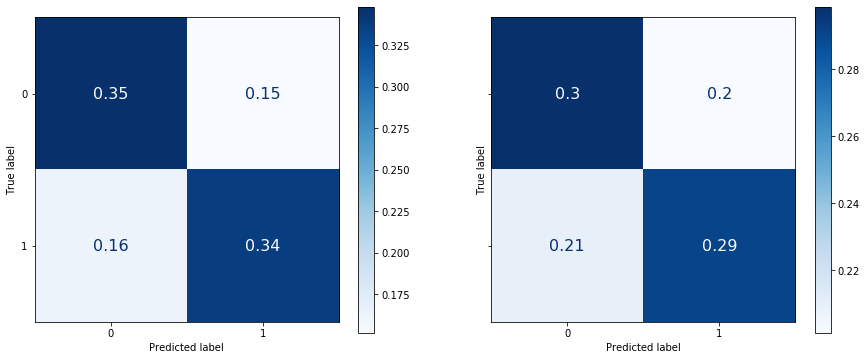

In [148]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
plot_confusion_matrix(model_2, reviews_train['text'], reviews_train['target'], cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(model_2, reviews_test['text'], reviews_test['target'], cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)

plt.show()

In [141]:
yhat_test = model_2.predict(reviews_test['text'])
yhat_train = model_2.predict(reviews_train['text'])
print(classification_report(reviews_train['target'], yhat_train))
print()
print(classification_report(reviews_test['target'], yhat_test))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     40000
           1       0.69      0.67      0.68     40000

    accuracy                           0.69     80000
   macro avg       0.69      0.69      0.69     80000
weighted avg       0.69      0.69      0.69     80000


              precision    recall  f1-score   support

           0       0.59      0.60      0.59     10000
           1       0.59      0.58      0.59     10000

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000



In [142]:
probabilities_train = model_2.predict_proba(reviews_train['text'])
probabilities_test = model_2.predict_proba(reviews_test['text'])

In [151]:
cmap = ListedColormap(sns.color_palette("husl", len(model_2.classes_)))

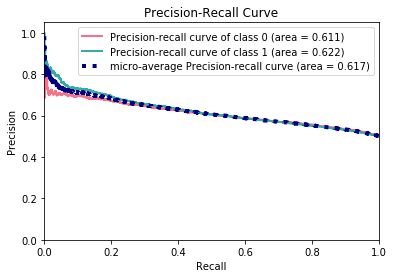

In [152]:

skplt.metrics.plot_precision_recall(reviews_test['target'], probabilities_test, cmap=cmap)
plt.show()

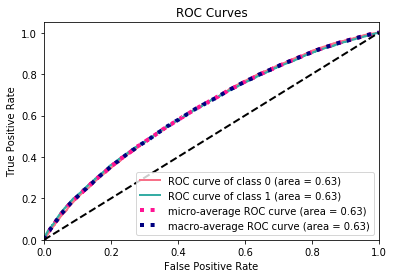

In [153]:
skplt.metrics.plot_roc(reviews_test['target'], probabilities_test, cmap=cmap)
plt.show()

## TF-IDF ngrams (1,1)

In [10]:
# Lets use the stop_words argument to remove words like "and, the a"
tfidf = TfidfVectorizer(stop_words=stop, lowercase = True, 
                              strip_accents='unicode', ngram_range=(1,1))

# Fit out vectorizer using the train_data
tfidf.fit(reviews_train['text'])

#transform training data to sparse matrix
tfidf_mat = tfidf.transform(reviews_train['text'])

# words occuring
words = tfidf.get_feature_names()
print(words[0:1000])
print()
# number of different words
print(len(words))

['TM', 'aaa', 'aaaaaaaamazingly', 'aaaaaaanywhere', 'aaaaaah', 'aaaaaalright', 'aaaaah', 'aaaaahing', 'aaaaamazing', 'aaaaannd', 'aaaaannyway', 'aaaah', 'aaaahhh', 'aaaahhhs', 'aaaahing', 'aaaal', 'aaaalll', 'aaaalllll', 'aaaamazing', 'aaaand', 'aaaanyway', 'aaaazing', 'aaah', 'aaahhh', 'aaahhhmaaazing', 'aaamazing', 'aaand', 'aaarrrgghhhhh', 'aaawesooome', 'aac', 'aack', 'aafter', 'aah', 'aahahahaha', 'aahhhmaaayzing', 'aaia', 'aaked', 'aaliyah', 'aall', 'aam', 'aamazing', 'aamazingly', 'aamco', 'aaoge', 'aaron', 'aarp', 'aarti', 'aas', 'aaye', 'aayyyeeee', 'aayyyyy', 'ab', 'aback', 'abacus', 'abadan', 'abadi', 'abagail', 'abagails', 'abalone', 'abandon', 'abandoned', 'abatement', 'abattoir', 'abba', 'abbas', 'abbey', 'abbott', 'abbreviated', 'abbreviation', 'abbruo', 'abby', 'abc', 'abc123', 'abd', 'abdc', 'abdelsayed', 'abdicates', 'abdomen', 'abdominal', 'abdul', 'abe', 'abel', 'abele', 'abeo', 'aber', 'abercrombie', 'aberration', 'aberrations', 'aberthon', 'abf', 'abhor', 'abhorre

In [11]:
X_train = tfidf_mat
y_train = reviews_train["target"]
X_test = tfidf.transform(reviews_test["text"])
y_test = reviews_test["target"]

In [195]:
X_train.shape

(80000, 65796)

In [196]:
y_train.shape

(80000,)

In [197]:
X_test.shape

(20000, 65796)

In [198]:
y_test.shape

(20000,)

## Classifier comparison

In [15]:
models = {
    'NB Bernoulli': (BernoulliNB(), {}),
    'Logistic Regression': (LogisticRegression(solver='saga'), {'C': np.linspace(3, 6, 15), 
                                                                     'penalty': ['l2']}), # 'l1'
    'LinearSVC': (LinearSVC(), {'penalty': ['l2'],
                                'class_weight': [None, 'balanced'],
                                'C': np.linspace(1, 10, 5)}),
    'RbfSVC': (SVC(kernel='rbf'), {'gamma': ['scale', 'auto']}),
#                                 'C': np.linspace(1, 100, 10)}),
#     'KNN': (KNeighborsClassifier(), {'n_neighbors': [15, 20, 30]})
}

    
gs_params = {
    'n_jobs': 2,
    'verbose': 2,
    'cv': 5, # 4
    'scoring': 'accuracy', # 'recall'
    'return_train_score': True
} 

for key, val in models.items():
    print('Model: ', key)
    gs = GridSearchCV(val[0], param_grid=val[1], **gs_params)
    
#     t0 = time()
    gs.fit(X_train, y_train)
#     train_time = time() - t0
#     print(("Train time: %0.3fs" % train_time))
    
    pred_train = gs.predict(X_train)
    pred_test = gs.predict(X_test)
    print("Best model: ", gs.best_estimator_)
    print("Best params: ", gs.best_params_)
    print("Train accuracy: ", gs.best_score_)
    print("Test accuracy: ", gs.score(X_test, y_test))
    print("Train recall (class 1): ", np.round(recall_score(y_train, pred_train, average='binary', pos_label=1),3))
    print("Test recall (class 1): ", np.round(recall_score(y_test, pred_test, average='binary', pos_label=1),3)) # average='macro'
    
    print('\nconfusion matrix: ')
    print(confusion_matrix(y_test, pred_test))
    print('\n')
    print(classification_report(y_test, pred_test))
    dump(gs, f'{key}_tfidf_1_1.joblib')
    print('-' * 60)

Model:  NB Bernoulli
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.9s finished


Best model:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Best params:  {}
Train accuracy:  0.6243875000000001
Test accuracy:  0.6247
Train recall (class 1):  0.499
Test recall (class 1):  0.481

confusion matrix: 
[[7681 2319]
 [5187 4813]]


              precision    recall  f1-score   support

           0       0.60      0.77      0.67     10000
           1       0.67      0.48      0.56     10000

    accuracy                           0.62     20000
   macro avg       0.64      0.62      0.62     20000
weighted avg       0.64      0.62      0.62     20000

------------------------------------------------------------
Model:  Logistic Regression
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:  6.0min finished


Best model:  LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best params:  {'C': 3.0, 'penalty': 'l2'}
Train accuracy:  0.6096375
Test accuracy:  0.61245
Train recall (class 1):  0.738
Test recall (class 1):  0.603

confusion matrix: 
[[6216 3784]
 [3967 6033]]


              precision    recall  f1-score   support

           0       0.61      0.62      0.62     10000
           1       0.61      0.60      0.61     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000

------------------------------------------------------------
Model:  LinearSVC
Fitting 5 folds for each of 10 candidates, totalling 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  9.0min finished


Best model:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best params:  {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}
Train accuracy:  0.5964750000000001
Test accuracy:  0.59865
Train recall (class 1):  0.787
Test recall (class 1):  0.582

confusion matrix: 
[[6150 3850]
 [4177 5823]]


              precision    recall  f1-score   support

           0       0.60      0.61      0.61     10000
           1       0.60      0.58      0.59     10000

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000

------------------------------------------------------------
Model:  RbfSVC
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 452.2min finished


Best model:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best params:  {'gamma': 'scale'}
Train accuracy:  0.6223124999999999
Test accuracy:  0.6251
Train recall (class 1):  0.921
Test recall (class 1):  0.605

confusion matrix: 
[[6454 3546]
 [3952 6048]]


              precision    recall  f1-score   support

           0       0.62      0.65      0.63     10000
           1       0.63      0.60      0.62     10000

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.62     20000
weighted avg       0.63      0.63      0.62     20000

------------------------------------------------------------


In [155]:
nb_bernoulli_tfidf_1_1 = load('NB Bernoulli_tfidf_1_1.joblib')

In [29]:
logreg_tfidf_1_1 = load('Logistic Regression_tfidf_1_1.joblib') 

In [18]:
rbfsvc_tfidf_1_1 = load('RbfSVC_tfidf_1_1.joblib')

In [20]:
linearsvc_1_1 = load('LinearSVC_tfidf_1_1.joblib')

In [31]:
logreg_tfidf_1_1_coef = pd.DataFrame({'words': tfidf.get_feature_names(),
                            'coefs': logreg_tfidf_1_1.best_estimator_.coef_[0]})
logreg_tfidf_1_1_coef.head()

,words,coefs
0,TM,-0.392191
1,aaa,0.112839
2,aaaaaaaamazingly,-0.332431
3,aaaaaaanywhere,-0.260577
4,aaaaaah,-0.163182


In [36]:
logreg_tfidf_1_1_coef.set_index('words', inplace=True)
logreg_tfidf_1_1_coef.head(20)

,coefs,coef_abs
words,,
TM,-0.392191,0.392191
aaa,0.112839,0.112839
aaaaaaaamazingly,-0.332431,0.332431
aaaaaaanywhere,-0.260577,0.260577
aaaaaah,-0.163182,0.163182
aaaaaalright,-0.418164,0.418164
aaaaah,0.111878,0.111878
aaaaahing,0.159045,0.159045
aaaaamazing,0.337105,0.337105


In [170]:
logreg_tfidf_1_1_coef['coef_abs'] = logreg_tfidf_1_1_coef.coefs.abs().sort_values()
logreg_tfidf_1_1_coef

,coefs,coef_abs
words,,
TM,-0.392191,0.392191
aaa,0.112839,0.112839
aaaaaaaamazingly,-0.332431,0.332431
aaaaaaanywhere,-0.260577,0.260577
aaaaaah,-0.163182,0.163182
...,...,...
zza,-0.597106,0.597106
zzeek,0.342851,0.342851
zzeeks,0.536310,0.536310


In [41]:
logreg_tfidf_1_1_coef.coefs.describe()

count    65796.000000
mean         0.078541
std          0.512346
min         -2.769751
25%         -0.254672
50%          0.076858
75%          0.324305
max          3.461385
Name: coefs, dtype: float64

In [171]:
logreg_tfidf_1_1_coef[logreg_tfidf_1_1_coef.coef_abs < 0.5][['coef_abs']].sort_values(by='coef_abs').plot(kind='barh', figsize=(50,50))

Error in callback <function flush_figures at 0x1165868c0> (for post_execute):


KeyboardInterrupt: 

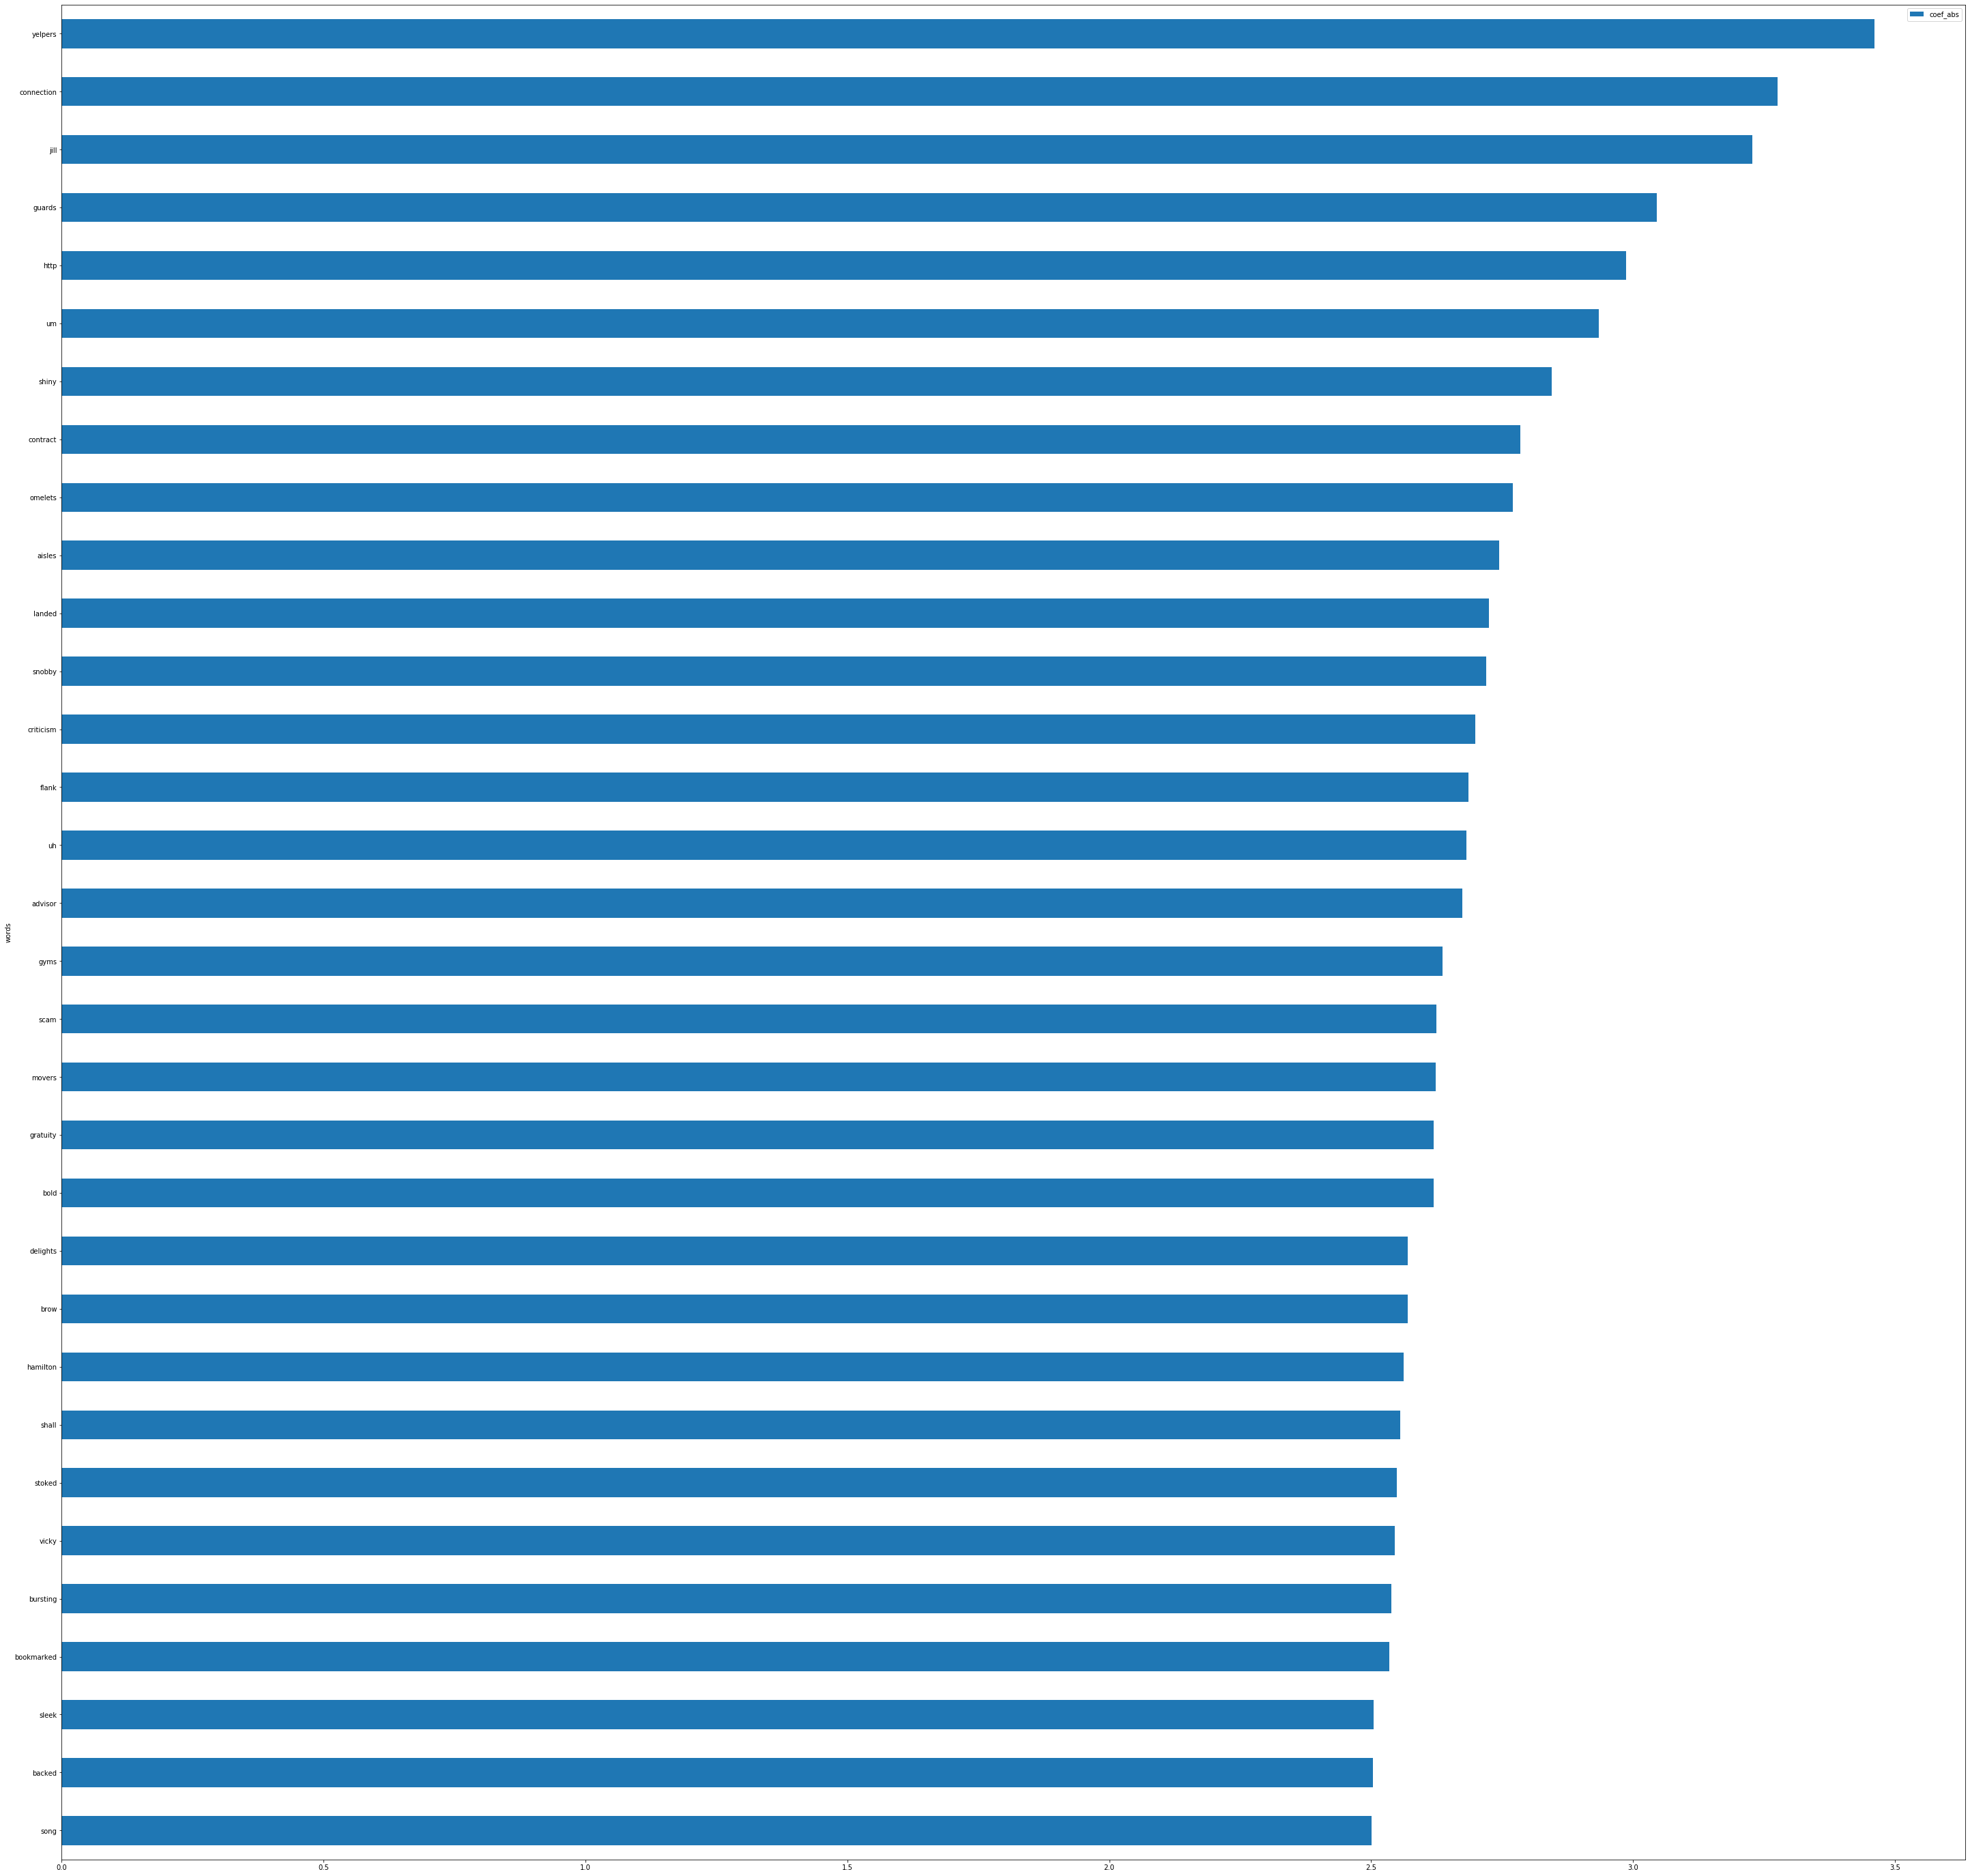

In [159]:
logreg_tfidf_1_1_coef[logreg_tfidf_1_1_coef.coef_abs > 2.5][['coef_abs']].sort_values(by='coef_abs').plot(kind='barh', figsize=(50,50))

In [35]:
##################################

In [45]:
# Lets use the stop_words argument to remove words like "and, the a"
tfidf1_2 = TfidfVectorizer(stop_words=stop, lowercase = True, 
                              strip_accents='unicode', ngram_range=(1,2))

# Fit out vectorizer using the train_data
tfidf1_2.fit(reviews_train['text'])

#transform training data to sparse matrix
tfidf1_2_mat = tfidf1_2.transform(reviews_train['text'])

# words occuring
words = tfidf1_2.get_feature_names()
print(words[0:1000])
print()
# number of different words
print(len(words))

['TM', 'TM come', 'aaa', 'aaa ability', 'aaa absolutely', 'aaa back', 'aaa ballantyne', 'aaa beef', 'aaa came', 'aaa camelback', 'aaa car', 'aaa card', 'aaa complaint', 'aaa coupon', 'aaa customers', 'aaa cvs', 'aaa cynthia', 'aaa discount', 'aaa effective', 'aaa five', 'aaa fortunate', 'aaa get', 'aaa grade', 'aaa grocery', 'aaa ground', 'aaa guy', 'aaa honda', 'aaa husbands', 'aaa jump', 'aaa landscaping', 'aaa loved', 'aaa man', 'aaa member', 'aaa membership', 'aaa michelin', 'aaa moment', 'aaa name', 'aaa nearly', 'aaa number', 'aaa office', 'aaa ok', 'aaa pay', 'aaa plus', 'aaa ps', 'aaa put', 'aaa rate', 'aaa rated', 'aaa reaches', 'aaa result', 'aaa road', 'aaa service', 'aaa srviceman', 'aaa steak', 'aaa tow', 'aaa truck', 'aaa twenty', 'aaa uni', 'aaa using', 'aaa usually', 'aaa wait', 'aaa weeks', 'aaa would', 'aaaaaaaamazingly', 'aaaaaaaamazingly good', 'aaaaaaanywhere', 'aaaaaaanywhere ill', 'aaaaaah', 'aaaaaah lobster', 'aaaaaalright', 'aaaaaalright may', 'aaaaah', 'aaaaah

In [51]:
csum_tfidf = word_counter(tfidf1_2_mat)
csum_tfidf

array([0.2082173 , 0.2082173 , 4.85611697, ..., 0.09577622, 0.08493076,
       0.08493076])

In [54]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(words, csum_tfidf), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.head(20)

,frequency
word,
food,1143.565616
great,1083.432486
good,1034.257135
place,1027.480702
service,891.874534
time,744.666832
like,687.942619
back,685.904482
get,685.695201


In [ ]:
df = pd.DataFrame(tfidf1_2_mat.toarray(), columns=tfidf1_2.get_feature_names())
df.transpose().sort_values(by=0, ascending=False).transpose()

In [64]:
X_train = tfidf1_2_mat
y_train = reviews_train["target"]
X_test = tfidf1_2.transform(reviews_test["text"])
y_test = reviews_test["target"]

In [70]:
models = {
    'NB Bernoulli': (BernoulliNB(), {}),
    'Logistic Regression': (LogisticRegression(solver='saga'), {'C': np.linspace(3, 6, 15), 
                                                                     'penalty': ['l2']}), # 'l1'
    'LinearSVC': (LinearSVC(), {'penalty': ['l2'],
                                'class_weight': [None, 'balanced'],
                                'C': np.linspace(1, 10, 5)}),
    'RbfSVC': (SVC(kernel='rbf'), {'gamma': ['scale', 'auto']}),
#                                 'C': np.linspace(1, 100, 10)}),
#     'KNN': (KNeighborsClassifier(), {'n_neighbors': [15, 20, 30]})
}
    
gs_params = {
    'n_jobs': 2,
    'verbose': 0,
    'cv': 5, # 4
    'scoring': 'accuracy', # 'recall'
    'return_train_score': True
} 

for key, val in models.items():
    print('Model: ', key)
    gs = GridSearchCV(val[0], param_grid=val[1], **gs_params)
    
#     t0 = time()
    gs.fit(X_train, y_train)
#     train_time = time() - t0
#     print(("Train time: %0.3fs" % train_time))
    
    pred_train = gs.predict(X_train)
    pred_test = gs.predict(X_test)
    print("Best model: ", gs.best_estimator_)
    print("Best params: ", gs.best_params_)
    print("Train accuracy: ", gs.best_score_)
    print("Test accuracy: ", gs.score(X_test, y_test))
    print("Train recall (class 1): ", np.round(recall_score(y_train, pred_train, average='binary', pos_label=1),3))
    print("Test recall (class 1): ", np.round(recall_score(y_test, pred_test, average='binary', pos_label=1),3)) # average='macro'
    
    print('\nconfusion matrix: ')
    print(confusion_matrix(y_test, pred_test))
    print('\n')
    print(classification_report(y_test, pred_test))
    dump(gs, f'{key}_tfidf_1_2.joblib')
    print('-' * 60)

Model:  NB Bernoulli
Best model:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Best params:  {}
Train accuracy:  0.5910375
Test accuracy:  0.5987
Train recall (class 1):  0.523
Test recall (class 1):  0.316

confusion matrix: 
[[8816 1184]
 [6842 3158]]


              precision    recall  f1-score   support

           0       0.56      0.88      0.69     10000
           1       0.73      0.32      0.44     10000

    accuracy                           0.60     20000
   macro avg       0.65      0.60      0.56     20000
weighted avg       0.65      0.60      0.56     20000

------------------------------------------------------------
Model:  Logistic Regression
Best model:  LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
 

In [72]:
dump(gs, 'gs_tfidf_1_2.joblib')

['gs_tfidf_1_2.joblib']

In [1]:
gs_tfidf_1_2 = load('gs_tfidf_1_2.joblib')

NameError: name 'load' is not defined

In [91]:
gs_tfidf_1_2.best_estimator_.coef0

0.0

In [46]:
gs_tfidf_1_2_coef = pd.DataFrame({'words': tfidf1_2.get_feature_names(),
                            'coefs': LogisticRegression_tfidf_1_2.best_estimator_.coef_[0]})
gs_tfidf_1_2_coef.head()

NameError: name 'LogisticRegression_tfidf_1_2' is not defined

In [103]:
models = {
    'Logistic Regression': (LogisticRegression(solver='saga'), {'C': [3], 
                                                                     'penalty': ['l2']}), # 'l1'
    'LinearSVC': (LinearSVC(), {'penalty': ['l2'],
                                'class_weight': [None],
                                'C': [1]}),
}
    
gs_params = {
    'n_jobs': 2,
    'verbose': 0,
    'cv': 5, # 4
    'scoring': 'accuracy', # 'recall'
    'return_train_score': True
} 

for key, val in models.items():
    print('Model: ', key)
    gs = GridSearchCV(val[0], param_grid=val[1], **gs_params)
    
#     t0 = time()
    gs.fit(X_train, y_train)
#     train_time = time() - t0
#     print(("Train time: %0.3fs" % train_time))
    
    pred_train = gs.predict(X_train)
    pred_test = gs.predict(X_test)
    print("Best model: ", gs.best_estimator_)
    print("Best params: ", gs.best_params_)
    print("Train accuracy: ", gs.best_score_)
    print("Test accuracy: ", gs.score(X_test, y_test))
    print("Train recall (class 1): ", np.round(recall_score(y_train, pred_train, average='binary', pos_label=1),3))
    print("Test recall (class 1): ", np.round(recall_score(y_test, pred_test, average='binary', pos_label=1),3)) # average='macro'
    
    print('\nconfusion matrix: ')
    print(confusion_matrix(y_test, pred_test))
    print('\n')
    print(classification_report(y_test, pred_test))
    dump(gs, f'{key}_tfidf_1_2.joblib')
    print('-' * 60)

Model:  Logistic Regression
Best model:  LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best params:  {'C': 3, 'penalty': 'l2'}
Train accuracy:  0.62255
Test accuracy:  0.62165
Train recall (class 1):  0.962
Test recall (class 1):  0.689

confusion matrix: 
[[5547 4453]
 [3114 6886]]


              precision    recall  f1-score   support

           0       0.64      0.55      0.59     10000
           1       0.61      0.69      0.65     10000

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000

------------------------------------------------------------
Model:  LinearSVC
Best model:  LinearSVC(C=1, cla

In [218]:
logreg_tfidf_1_2.best_estimator_.coef_

array([[-0.18109406, -0.18109406,  0.15945349, ...,  0.05363735,
         0.03874136,  0.03874136]])

In [177]:
logreg_tfidf_1_2 = load('Logistic Regression_tfidf_1_2.joblib')

In [181]:
models = {
    'Logistic_Regression': (LogisticRegression(solver='saga'), {'C': [3], 
                                                                     'penalty': ['l2']}), # 'l1'
     
gs_params = {
    'n_jobs': 2,
    'verbose': 0,
    'cv': 5, # 4
    'scoring': 'accuracy', # 'recall'
    'return_train_score': True
} 

for key, val in models.items():
    print('Model: ', key)
    gs = GridSearchCV(val[0], param_grid=val[1], **gs_params)
    
#     t0 = time()
    gs.fit(X_train, y_train)
#     train_time = time() - t0
#     print(("Train time: %0.3fs" % train_time))
    
    pred_train = gs.predict(X_train)
    pred_test = gs.predict(X_test)
    print("Best model: ", gs.best_estimator_)
    print("Best params: ", gs.best_params_)
    print("Train accuracy: ", gs.best_score_)
    print("Test accuracy: ", gs.score(X_test, y_test))
    print("Train recall (class 1): ", np.round(recall_score(y_train, pred_train, average='binary', pos_label=1),3))
    print("Test recall (class 1): ", np.round(recall_score(y_test, pred_test, average='binary', pos_label=1),3)) # average='macro'
    
    print('\nconfusion matrix: ')
    print(confusion_matrix(y_test, pred_test))
    print('\n')
    print(classification_report(y_test, pred_test))
    dump(gs, f'{key}_tfidf_1_2.joblib')
    print('-' * 60)

SyntaxError: invalid syntax (<ipython-input-181-c516b3c6f72e>, line 5)

In [179]:
logistic_regression_coef = pd.DataFrame({'words': tfidf1_2.get_feature_names(),
                            'coefs': Logistic Regression.best_estimator_.coef_[0]})

SyntaxError: invalid syntax (<ipython-input-179-96dc113539ab>, line 2)

In [253]:
df_coef.head(60)

,coefficients
TM,-0.181094
TM come,-0.181094
aaa,0.159453
aaa ability,0.018496
aaa absolutely,0.043747
aaa back,0.074736
aaa ballantyne,-0.149976
aaa beef,0.063863
aaa came,-0.117468
aaa camelback,-0.139127


In [255]:
df_coef['coef_abs'] = df_coef.coefficients.abs()

In [257]:
df_coef

,coefficients,coef_abs
TM,-0.181094,0.181094
TM come,-0.181094,0.181094
aaa,0.159453,0.159453
aaa ability,0.018496,0.018496
aaa absolutely,0.043747,0.043747
...,...,...
zzzz,0.149309,0.149309
zzzz food,0.101082,0.101082
zzzz great,0.053637,0.053637
zzzzzz,0.038741,0.038741


In [286]:
logreg_mask = df_coef[df_coef.coef_abs > 2][['coef_abs']].sort_values(by='coef_abs')

In [287]:
logreg_mask

,coef_abs
body,2.005326
forget,2.007000
omelets,2.007799
rip,2.014644
part,2.015241
...,...
perhaps,2.635812
tender,2.651049
yelpers,2.931298
addition,3.052962


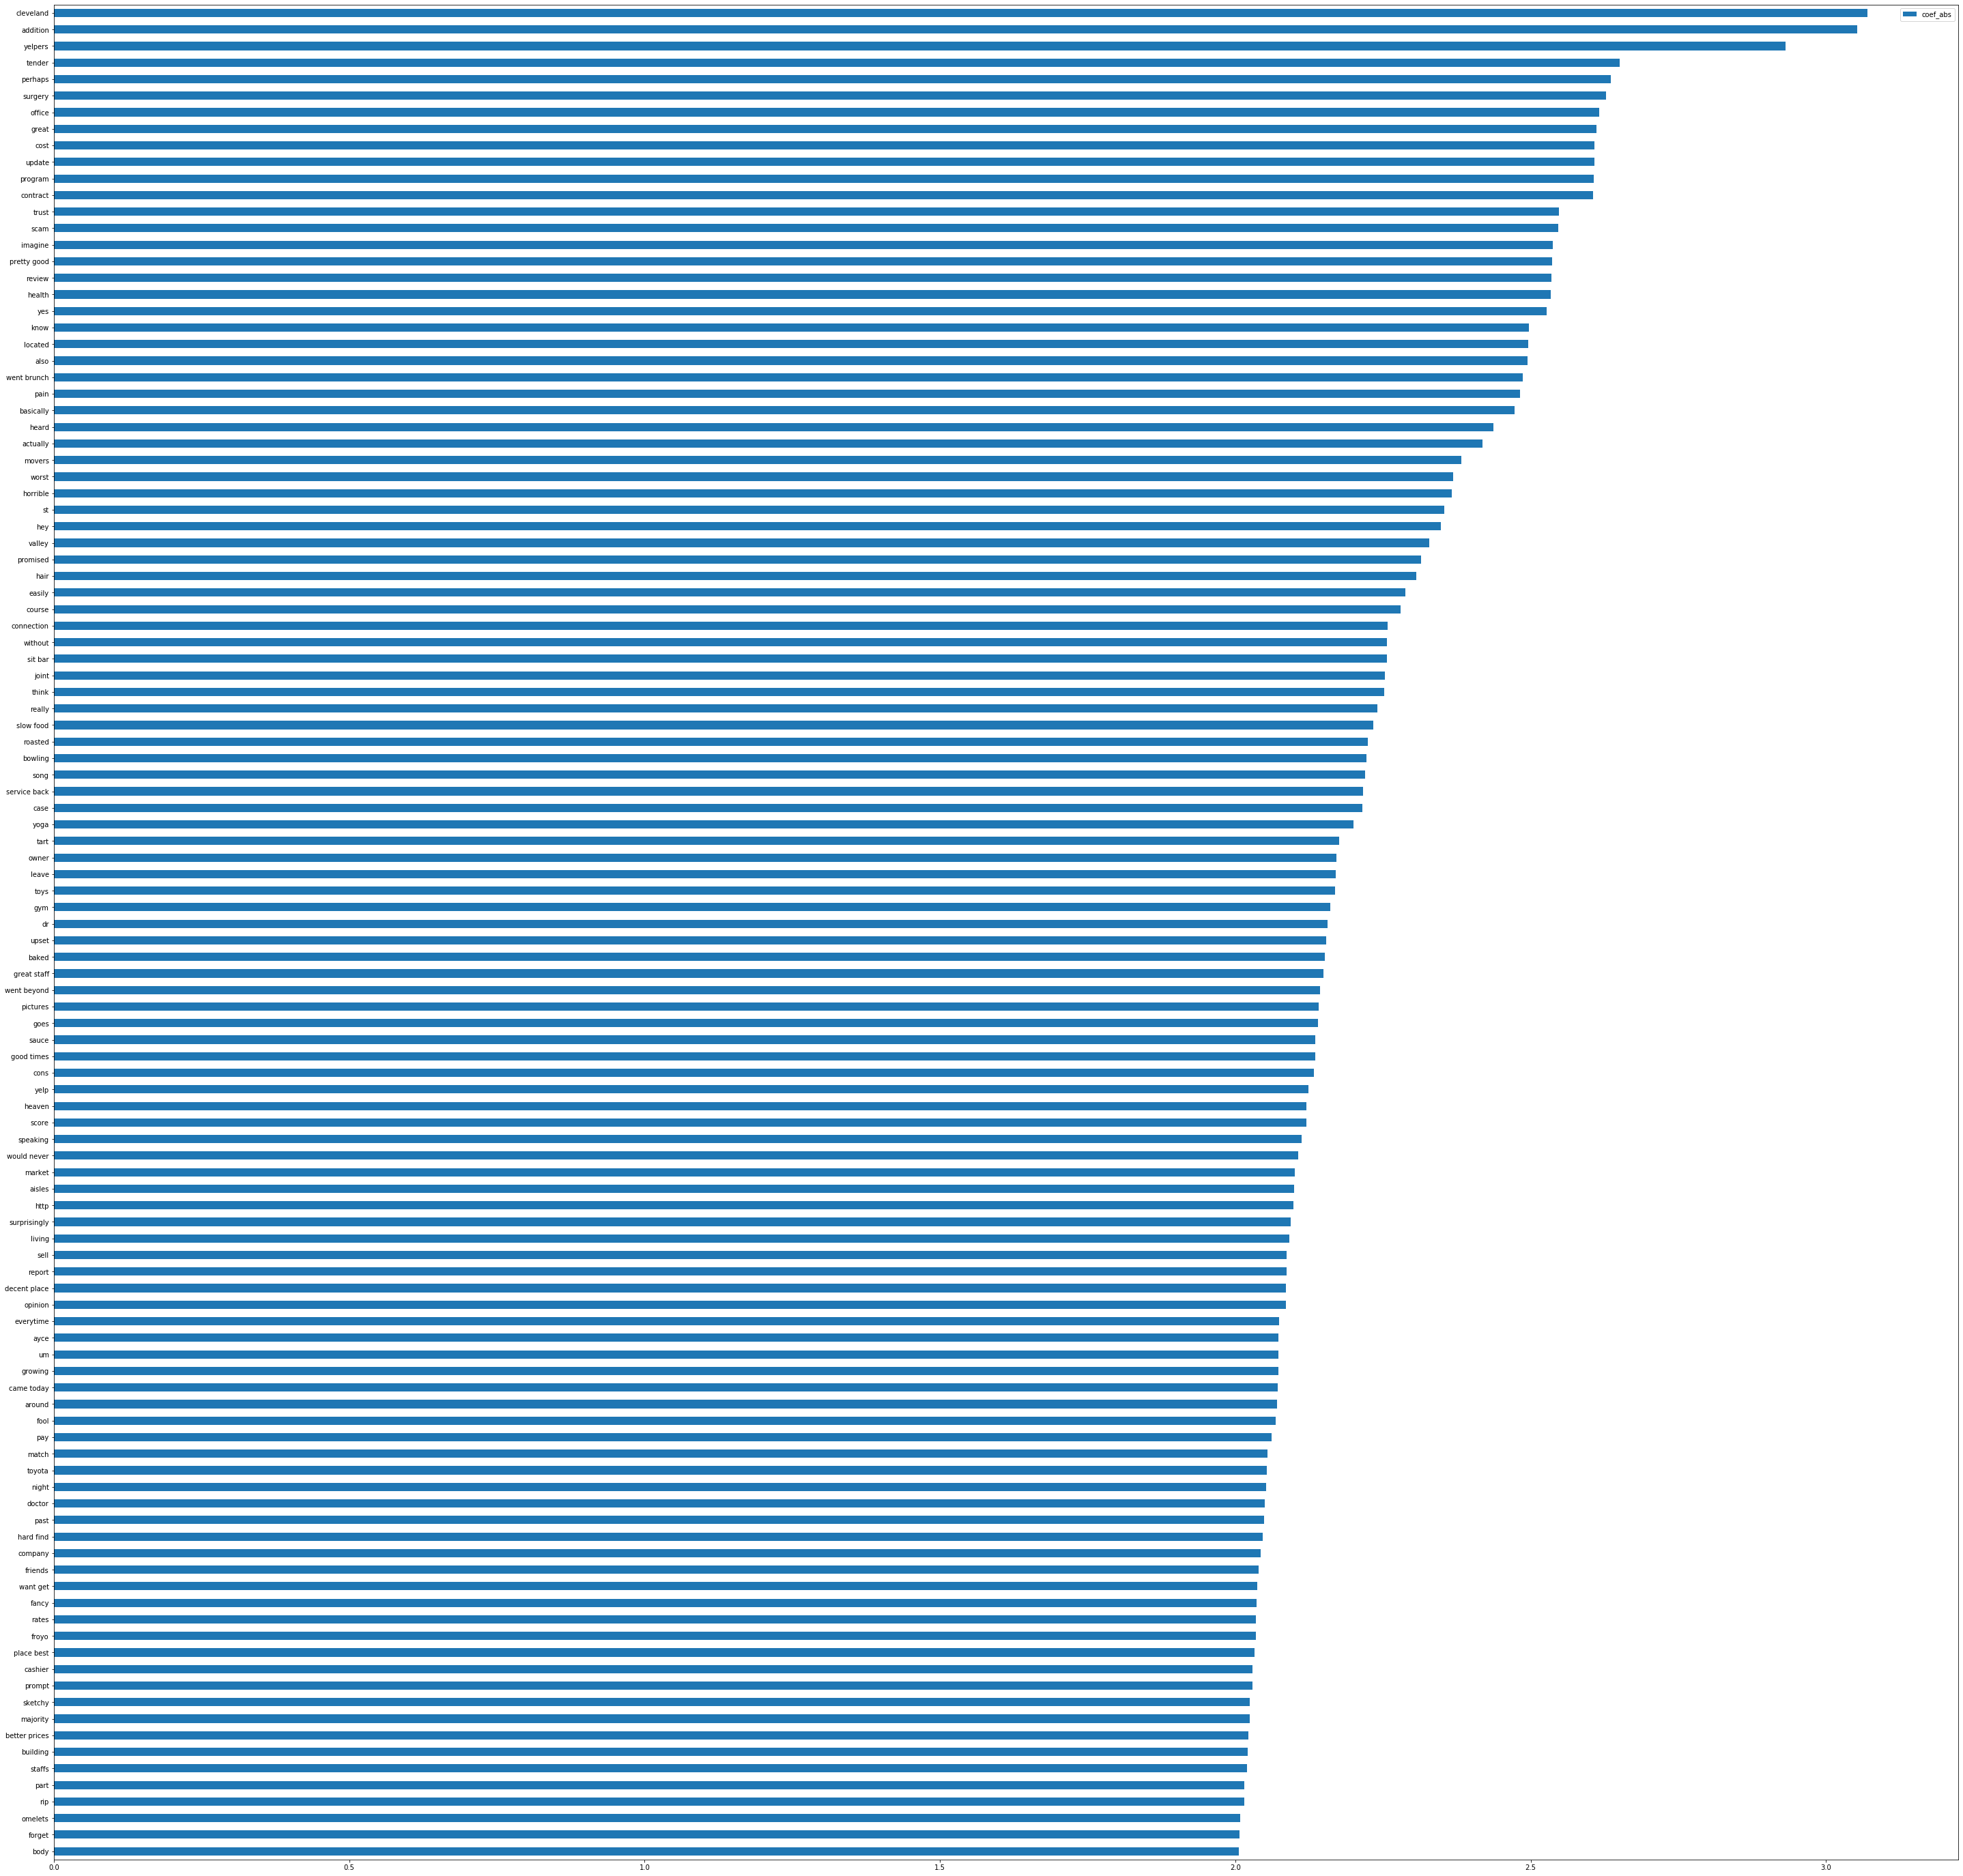

In [288]:
logreg_mask[logreg_mask.coef_abs > 2][['coef_abs']].sort_values(by='coef_abs').plot(kind='barh', figsize=(50,50))

In [52]:
def get_freq_words(sparse_counts, columns):
    word_counts = np.ravel(sparse_counts.sum(axis=0))
    freq_words = pd.Series(
        word_counts, index=columns).sort_values(ascending=False)
    return freq_words

In [53]:
freq_words = get_freq_words(logreg_mask, columns)

NameError: name 'logreg_mask' is not defined

In [ ]:
from wordcloud import WordCloud
pos_wc = WordCloud(background_color="white", max_words=50).generate_from_frequencies(frequencies=freq_words)
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(pos_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## Train data clean, text tokens, text token stems

In [67]:
import re
def clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(reviews_train, 'text', 'text_clean')
data_clean.head()

/Users/mymacbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mymacbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/mymacbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is tryin

,text,target,text_clean,text_tokens,text_tokens_stem
18961,"I met the owner of the restaurant at a show, a...",0,i met the owner of the restaurant at a show an...,"[i, met, the, owner, of, the, restaurant, at, ...","[i, met, the, owner, of, the, restaur, at, a, ..."
10938,Great Fresh sushi anytime we go. Staff is grea...,0,great fresh sushi anytime we go staff is great...,"[great, fresh, sushi, anytime, we, go, staff, ...","[great, fresh, sushi, anytim, we, go, staff, i..."
28948,Not a bad place. It was a little pricy but its...,0,not a bad place it was a little pricy but its ...,"[not, a, bad, place, it, was, a, little, pricy...","[not, a, bad, place, it, wa, a, littl, prici, ..."
24558,"Just had a delicious Cobb salad, chicken was t...",0,just had a delicious cobb salad chicken was te...,"[just, had, a, delicious, cobb, salad, chicken...","[just, had, a, delici, cobb, salad, chicken, w..."
89402,Worst Walmart ever. Not only is it small (use...,1,worst walmart ever not only is it small used ...,"[worst, walmart, ever, not, only, is, it, smal...","[worst, walmart, ever, not, onli, is, it, smal..."


In [68]:
import nltk 
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x: word_tokenize(x))
data_clean.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mymacbookpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/mymacbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,text,target,text_clean,text_tokens,text_tokens_stem
18961,"I met the owner of the restaurant at a show, a...",0,i met the owner of the restaurant at a show an...,"[i, met, the, owner, of, the, restaurant, at, ...","[i, met, the, owner, of, the, restaur, at, a, ..."
10938,Great Fresh sushi anytime we go. Staff is grea...,0,great fresh sushi anytime we go staff is great...,"[great, fresh, sushi, anytime, we, go, staff, ...","[great, fresh, sushi, anytim, we, go, staff, i..."
28948,Not a bad place. It was a little pricy but its...,0,not a bad place it was a little pricy but its ...,"[not, a, bad, place, it, was, a, little, pricy...","[not, a, bad, place, it, wa, a, littl, prici, ..."
24558,"Just had a delicious Cobb salad, chicken was t...",0,just had a delicious cobb salad chicken was te...,"[just, had, a, delicious, cobb, salad, chicken...","[just, had, a, delici, cobb, salad, chicken, w..."
89402,Worst Walmart ever. Not only is it small (use...,1,worst walmart ever not only is it small used ...,"[worst, walmart, ever, not, only, is, it, smal...","[worst, walmart, ever, not, onli, is, it, smal..."


In [ ]:
test = data_clean.to_csv('data_clean')

In [90]:
import nltk 
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x: word_tokenize(x)
data_clean.head()

SyntaxError: invalid syntax (<ipython-input-90-37627dbeb3fc>, line 5)

In [88]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return " ".join(stem_text)
data_clean['text_tokens_stem'] = data_clean['text_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head()

/Users/mymacbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,text,target,text_clean,text_tokens,text_tokens_stem,text_tokens_pos_tagged
18961,"I met the owner of the restaurant at a show, a...",0,i met the owner of the restaurant at a show an...,"[i, met, the, owner, of, the, restaurant, at, ...",i met the owner of the restaur at a show and m...,"[(i, NN), (met, VBD), (the, DT), (owner, NN), ..."
10938,Great Fresh sushi anytime we go. Staff is grea...,0,great fresh sushi anytime we go staff is great...,"[great, fresh, sushi, anytime, we, go, staff, ...",great fresh sushi anytim we go staff is great ...,"[(great, JJ), (fresh, JJ), (sushi, NN), (anyti..."
28948,Not a bad place. It was a little pricy but its...,0,not a bad place it was a little pricy but its ...,"[not, a, bad, place, it, was, a, little, pricy...",not a bad place it wa a littl prici but it nic...,"[(not, RB), (a, DT), (bad, JJ), (place, NN), (..."
24558,"Just had a delicious Cobb salad, chicken was t...",0,just had a delicious cobb salad chicken was te...,"[just, had, a, delicious, cobb, salad, chicken...",just had a delici cobb salad chicken wa tender...,"[(just, RB), (had, VBD), (a, DT), (delicious, ..."
89402,Worst Walmart ever. Not only is it small (use...,1,worst walmart ever not only is it small used ...,"[worst, walmart, ever, not, only, is, it, smal...",worst walmart ever not onli is it small use to...,"[(worst, JJS), (walmart, NN), (ever, RB), (not..."


In [ ]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
word_list = ['rains', 'raining', 'rain', 'rained']
ps = PorterStemmer()
for w in word_list:
    print(ps.stem(w))

In [71]:
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return " ".join(pos_tagged_text)
nltk.download('averaged_perceptron_tagger')
data_clean['text_tokens_pos_tagged'] = data_clean['text_tokens'].apply(lambda x: word_pos_tagger(x))
data_clean.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mymacbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/Users/mymacbookpro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,target,text_clean,text_tokens,text_tokens_stem,text_tokens_pos_tagged
18961,"I met the owner of the restaurant at a show, a...",0,i met the owner of the restaurant at a show an...,"[i, met, the, owner, of, the, restaurant, at, ...","[i, met, the, owner, of, the, restaur, at, a, ...","[(i, NN), (met, VBD), (the, DT), (owner, NN), ..."
10938,Great Fresh sushi anytime we go. Staff is grea...,0,great fresh sushi anytime we go staff is great...,"[great, fresh, sushi, anytime, we, go, staff, ...","[great, fresh, sushi, anytim, we, go, staff, i...","[(great, JJ), (fresh, JJ), (sushi, NN), (anyti..."
28948,Not a bad place. It was a little pricy but its...,0,not a bad place it was a little pricy but its ...,"[not, a, bad, place, it, was, a, little, pricy...","[not, a, bad, place, it, wa, a, littl, prici, ...","[(not, RB), (a, DT), (bad, JJ), (place, NN), (..."
24558,"Just had a delicious Cobb salad, chicken was t...",0,just had a delicious cobb salad chicken was te...,"[just, had, a, delicious, cobb, salad, chicken...","[just, had, a, delici, cobb, salad, chicken, w...","[(just, RB), (had, VBD), (a, DT), (delicious, ..."
89402,Worst Walmart ever. Not only is it small (use...,1,worst walmart ever not only is it small used ...,"[worst, walmart, ever, not, only, is, it, smal...","[worst, walmart, ever, not, onli, is, it, smal...","[(worst, JJS), (walmart, NN), (ever, RB), (not..."


In [72]:
data_clean.to_csv('data_clean_2')

In [ ]:
data_clean.text_tokens_stem

In [105]:
cvec_none_token = CountVectorizer()

X = cvec_none_token.fit(data_clean['text_tokens_stem'])

columns = cvec_none_token.get_feature_names()

In [106]:
print(columns)

['aa', 'aaa', 'aaaaaaaamazingli', 'aaaaaaanywher', 'aaaaaah', 'aaaaaalright', 'aaaaah', 'aaaaahd', 'aaaaamaz', 'aaaaannd', 'aaaah', 'aaaahhh', 'aaaal', 'aaaalll', 'aaaalllll', 'aaaamaz', 'aaaand', 'aaaanyway', 'aaaaz', 'aaah', 'aaahhhd', 'aaahhhmaaaz', 'aaamaz', 'aaand', 'aaaok', 'aaarat', 'aaarrrgghhhhh', 'aaawesooom', 'aac', 'aacom', 'aaddress', 'aafter', 'aahahahahaprosciutto', 'aahhhmaaayz', 'aai', 'aaia', 'aak', 'aaliyah', 'aall', 'aam', 'aamaz', 'aamazingli', 'aamco', 'aaog', 'aaron', 'aarp', 'aarti', 'aatmosphereafoodafrom', 'aay', 'aayyyeee', 'ab', 'aback', 'abacu', 'abadan', 'abadi', 'abagail', 'abalon', 'abanana', 'abandon', 'abat', 'abattoir', 'abba', 'abbey', 'abbeyit', 'abbi', 'abbott', 'abbrevi', 'abbruo', 'abburn', 'abbyjuli', 'abc', 'abcd', 'abd', 'abdc', 'abdelsay', 'abdic', 'abdomen', 'abdomenmi', 'abdomin', 'abdul', 'abe', 'abeer', 'abel', 'abeo', 'aber', 'abercrombi', 'aberr', 'aberthon', 'abf', 'abhor', 'abhorr', 'abianc', 'abid', 'abier', 'abig', 'abigail', 'abil'

In [107]:
len(columns)

104084

In [109]:
cvec_none_token = CountVectorizer()

X = cvec_none_token.fit(data_clean['text_tokens_stem'])

#transform training data to sparse matrix
cvec_token = X.transform(data_clean['text_tokens_stem'])

In [110]:
X_train = cvec_token # cvec_mat = cvec.transform(reviews_train['text'])
y_train = reviews_train["target"]
X_test = cvec_none_token.transform(reviews_test["text"])
y_test = reviews_test["target"]

In [111]:
lr = LogisticRegression(solver='saga', max_iter=10000)
lr.fit(X_train, y_train)
print('Train score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print('CV mean:', cross_val_score(lr, X_train, y_train).mean())

Train score: 0.7815625
Test score: 0.58665


KeyboardInterrupt: 

In [ ]:
############

In [104]:
stop = stopwords.words('english')
stop += ['aaa', 'aaaaaaaamazingli', 'aaaaaaanywher', 'aaaaaah', 'aaaaaalright', 'aaaaah', 'aaaaahd', 'aaaaamaz', 'aaaaannd', 'aaaah', 'aaaahhh', 'aaaal', 'aaaalll', 'aaaalllll', 'aaaamaz', 'aaaand', 'aaaanyway', 'aaaaz', 'aaah', 'aaahhhd', 'aaahhhmaaaz', 'aaamaz', 'aaand', 'aaaok', 'aaarat', 'aaarrrgghhhhh', 'aaawesooom', 'aac', 'aacom', 'aaddress', 'aafter', 'aahahahahaprosciutto', 'aahhhmaaayz', 'aai', 'aaia', 'aak', 'aaliyah', 'aall', 'aam', 'aamaz', 'aamazingli', 'aamco', 'aaog', 'aaron', 'aarp', 'aarti', 'aatmosphereafoodafrom', 'aay', 'aayyyeee', 'ab', 'zuzu', 'zwoa', 'zx', 'zydeco', 'zyou', 'zyrtec', 'zyvox', 'zz', 'zzeek', 'zzzzgreat', 'zzzzthe']

In [91]:
# Lets use the stop_words argument to remove words like "and, the a"
tfidf = TfidfVectorizer(lowercase = True, stop_words=stop, strip_accents='unicode', ngram_range=(1,1))

# Fit out vectorizer using the train_data
tfidf.fit(data_clean['text_tokens_stem'])

#transform training data to sparse matrix
tfidf_mat = tfidf.transform(data_clean['text_tokens_stem'])

# words occuring
words = tfidf.get_feature_names()
print(words[0:1000])
print()
# number of different words
print(len(words))

['aaa', 'aaaaaaaamazingli', 'aaaaaaanywher', 'aaaaaah', 'aaaaaalright', 'aaaaah', 'aaaaahd', 'aaaaamaz', 'aaaaannd', 'aaaah', 'aaaahhh', 'aaaal', 'aaaalll', 'aaaalllll', 'aaaamaz', 'aaaand', 'aaaanyway', 'aaaaz', 'aaah', 'aaahhhd', 'aaahhhmaaaz', 'aaamaz', 'aaand', 'aaaok', 'aaarat', 'aaarrrgghhhhh', 'aaawesooom', 'aac', 'aacom', 'aaddress', 'aafter', 'aahahahahaprosciutto', 'aahhhmaaayz', 'aai', 'aaia', 'aak', 'aaliyah', 'aall', 'aam', 'aamaz', 'aamazingli', 'aamco', 'aaog', 'aaron', 'aarp', 'aarti', 'aatmosphereafoodafrom', 'aay', 'aayyyeee', 'ab', 'aback', 'abacu', 'abadan', 'abadi', 'abagail', 'abalon', 'abanana', 'abandon', 'abat', 'abattoir', 'abba', 'abbey', 'abbeyit', 'abbi', 'abbott', 'abbrevi', 'abbruo', 'abburn', 'abbyjuli', 'abc', 'abcd', 'abd', 'abdc', 'abdelsay', 'abdic', 'abdomen', 'abdomenmi', 'abdomin', 'abdul', 'abe', 'abeer', 'abel', 'abeo', 'aber', 'abercrombi', 'aberr', 'aberthon', 'abf', 'abhor', 'abhorr', 'abianc', 'abid', 'abier', 'abig', 'abigail', 'abil', 'abi

In [100]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop, lowercase = True, strip_accents='unicode')),
    ('logreg',LogisticRegression(solver = 'saga', max_iter = 10000))
                ])
param_grid = {'tfidf__min_df':[10,20,30,40], 
              'tfidf__max_features':[1000,10000,5000,50000]}

model = GridSearchCV(pipe, param_grid = param_grid, verbose = 2, cv = 5)

model.fit(data_clean['text_tokens_stem'], reviews_train['target'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] tfidf__max_features=1000, tfidf__min_df=10 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
lr = LogisticRegression(solver='saga', max_iter=10000)
lr.fit(X_train, y_train)
print('Train score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print('CV mean:', cross_val_score(lr, X_train, y_train).mean())